In [1]:
import pandas as pd
import numpy as np
import random
import collections
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import operator   
from scipy.stats import pearsonr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

## import dataset

In [2]:
df = pd.read_excel('Firefighter_food_time_HealthDataSet.xlsx')

In [3]:
df['group'] = ['baseline' if x  <= 14 else 'intervention' for x in df['Day since beginning of participant enrollment']]

In [4]:
len(df['Participant ID'].unique())

137

In [5]:
df=df[(df['Beverage(b)/Food(f)/Water(w)/medication(m)']=='f') | (df['Beverage(b)/Food(f)/Water(w)/medication(m)']=='b')]


## Data Cleaning

First, delete firefighter data with less than 10 days of entries since such data are not what we want to analyze

In [6]:
par_to_drop = []
for index, value in df['Participant ID'].value_counts().iteritems():

    if value < 10:
        par_to_drop.append(index)


In [7]:
df_by_par = df.set_index('Participant ID')

In [8]:
for par in par_to_drop:
    df_by_par.drop(par,inplace=True)

In [9]:
df = df_by_par.reset_index()

## Revise column name

In [10]:
df.rename({'Participant ID':'ParticipantID'}, axis='columns',inplace=True)
df.rename({'Day since beginning of participant enrollment':'DayPassed'}, axis='columns',inplace=True)

## Analysis

In [11]:
# set index
df_index = df.set_index(['ParticipantID','Date'])

check whether everyone have  roughly 14 days of entries in baseline.

check the maximum number of continuous days of records each participant has since the first day of baseline and intervention. This could provide some background information that could be useful for further analysis.

In [12]:

df_check = pd.DataFrame(df['ParticipantID'].unique())
df_check.rename({0:'ParticipantID'}, axis='columns',inplace=True)

In [13]:
df_check

,ParticipantID
0,9bbi18050005
1,9bbi18050009
2,9bbi18050011
3,9bbi18060012
4,9bbi18060013
...,...
131,9bbi19110168
132,9bbi19110169
133,9bbi19110171
134,9bbi19120173


'BaselineCheck' contains boolean values, indicating whether the participants has at least 12 days of record during baseline. We do not choose the threshold of 14 days here since doing that would exclude too many participants in our study.

'BaselineContinuous' and 'InterventionContinuous' contains numerical values, indicating how many continuous days of record each individual has since the start of baseline/intervention.

In [14]:
df_check['BaselineCheck'] = [False]*136
df_check['BaselineContinuous'] = np.repeat(0,136)
df_check['InterventionContinuous'] = np.repeat(0,136)
df_check.set_index(['ParticipantID'])

,BaselineCheck,BaselineContinuous,InterventionContinuous
ParticipantID,,,
9bbi18050005,False,0,0
9bbi18050009,False,0,0
9bbi18050011,False,0,0
9bbi18060012,False,0,0
9bbi18060013,False,0,0
...,...,...,...
9bbi19110168,False,0,0
9bbi19110169,False,0,0
9bbi19110171,False,0,0


In [15]:
# check whether everyone has more than 12 days in baseline record
arr = []
for parID in df['ParticipantID'].unique():

    length = len(df_index.query('ParticipantID == @parID and group == "baseline"')['DayPassed'].unique())
    if length >= 12:
        arr.append(True)
    else:
        arr.append(False)
df_check['BaselineCheck'] = arr

In [16]:
df_check

,ParticipantID,BaselineCheck,BaselineContinuous,InterventionContinuous
0,9bbi18050005,True,0,0
1,9bbi18050009,True,0,0
2,9bbi18050011,True,0,0
3,9bbi18060012,True,0,0
4,9bbi18060013,True,0,0
...,...,...,...,...
131,9bbi19110168,True,0,0
132,9bbi19110169,True,0,0
133,9bbi19110171,True,0,0
134,9bbi19120173,True,0,0


In [17]:
# check how many continuous days each have
def check_continuous(l):
    start = l[0]
    count = 1
    for day in l[1:]:
        if day == start + 1:
            count +=1
            start = day
        else: break
    return count

In [18]:
# check how many continuous days each have in baseline
arr = []
for parID in df['ParticipantID'].unique():

    daylist = df_index.query('ParticipantID == @parID and group == "baseline"')['DayPassed'].unique()
    count = check_continuous(daylist)
    arr.append(count)
df_check['BaselineContinuous'] = arr    

In [19]:
# check how many continuous days each have in intervention
arr = []
for parID in df['ParticipantID'].unique():

    daylist = df_index.query('ParticipantID == @parID and group == "intervention"')['DayPassed'].unique()
    count = check_continuous(daylist)
    arr.append(count)
df_check['InterventionContinuous'] = arr    

In [20]:
df_check

,ParticipantID,BaselineCheck,BaselineContinuous,InterventionContinuous
0,9bbi18050005,True,15,30
1,9bbi18050009,True,15,7
2,9bbi18050011,True,15,3
3,9bbi18060012,True,12,4
4,9bbi18060013,True,12,60
...,...,...,...,...
131,9bbi19110168,True,15,28
132,9bbi19110169,True,15,9
133,9bbi19110171,True,15,109
134,9bbi19120173,True,15,52


In [21]:
# drop participants whose Baseline Check is False (who has less than 12 days of record during baseline)
par_drop = np.array(df_check.query('BaselineCheck == False')['ParticipantID'])
df_index.reset_index(inplace=True)

df_index.set_index(['ParticipantID'],inplace=True)
for par in par_drop:
    df_index.drop(par,inplace=True)
df_index.reset_index(inplace=True)
df_index.set_index(['ParticipantID','Date'],inplace=True)

In [22]:
df_index.reset_index(inplace=True)
all_date_base = df_index['Date'].unique()
all_par_base = df_index['ParticipantID'].unique()
df_index.set_index(['ParticipantID','Date'],inplace=True)

In [23]:
all_date = df['Date'].unique()

In [24]:
all_par = df['ParticipantID'].unique()

In [25]:
df_inter67 = df_index[(df_index['DayPassed']>=38) & (df_index['DayPassed']<=52)]

Create several food dictionaries for future use. Each food dictionary has a double dictionary structure. For such a dictionary, keys are the unique ID of valid participants in the study. For each key, its corresponding value is another dictionary, with keys being the TimeStamp of the date that he or she made a record, and with values being the food items that he or she record during that day.

food_dict is a food dictionary containing all participants and all days in this experiment. 

food_dict_base is a food dictionary containing all participants but only the days in baseline in this experiement.

In [26]:
#make food log a dictionary for all days in experiment

food_dict_all= {}
for par in all_par:
    food_dict_all[par] = {}
    
    
    df_temp = df_index.query('ParticipantID == @par')
    df_temp.reset_index(inplace=True)
    dates = df_temp['Date'].unique()
    for date in dates:
        df_temp2 = df_temp.query('Date == @date')
    
        for index, value in df_temp2['Parsed food'].iteritems():
            if date not in food_dict_all[par].keys():
                food_dict_all[par][date] = [value]
            else:
                 food_dict_all[par][date].append(value)


In [27]:
#make food log for baseline only (0-14 days)

food_dict_base= {}
for par in all_par_base:
    food_dict_base[par] = {}
    
    df_temp = df_index.query('ParticipantID == @par and DayPassed <= 14')
    df_temp.reset_index(inplace=True)
    dates = df_temp['Date'].unique()
    for date in dates:
        df_temp2 = df_temp.query('Date == @date')
    
        for index, value in df_temp2['Parsed food'].iteritems():
            if date not in food_dict_base[par].keys():
                food_dict_base[par][date] = [value]
            else:
                 food_dict_base[par][date].append(value)

In [28]:
par_67 = df_inter67.reset_index()['ParticipantID'].unique()

In [29]:
#make food log for week6,7 in intervention period

food_dict_67= {}
for par in par_67:
    food_dict_67[par] = {}
    
    df_temp = df_index.query('ParticipantID == @par and DayPassed >= 38 and DayPassed <= 52')
    df_temp.reset_index(inplace=True)
    dates = df_temp['Date'].unique()
    for date in dates:
        df_temp2 = df_temp.query('Date == @date')
    
        for index, value in df_temp2['Parsed food'].iteritems():
            if date not in food_dict_67[par].keys():
                food_dict_67[par][date] = [value]
            else:
                 food_dict_67[par][date].append(value)

## Data sampling methods

In [30]:
#random subsample 
# for each participant, randomly sample 1,3,7,10,14days (n days)
"""
Generate random sampling of n days for participant parID

Parameter: 
----------
ndays: number of days we want the random sampling to contain
parID: the participant whom we want to sample data from

Return:
---------
food_par: an array containing food items that we sampled

"""
def random_sample(ndays,parID,food_dict):
    food_dict_par = food_dict[parID]
    keys = food_dict_par.keys()
    if len(keys) >= ndays:
        days_sampled = random.sample(keys, ndays) 
        food_par = []
        for day in days_sampled:
            food_par += food_dict_par[day]
        return food_par
    else:
        #return false if the participant do not have enough data
        print('not enough data')
        return False
    

In [31]:
# for each participant, sample consecutively n days
"""
Generate random consecutive sampling of n days for participant parID

Parameter: 
----------
ndays: number of days we want the random consecutive sampling to contain
parID: the participant whom we want to sample data from

Return:
---------
food_par: an array containing food items that we sampled

"""
def consecutive_sample(ndays,parID,food_dict):
    food_dict_par = food_dict[parID]
    keys = list(food_dict_par.keys())

    if len(keys) >= ndays:
        start = random.choice(range(0,len(keys)-ndays+1))
        food_par = []
        for i in range(ndays):
            food_par += food_dict_par[keys[start]]
            start+=1
        return food_par
    else:
         #return false if the participant do not have enough data
        print('not enough data')
        return False

In [32]:
# calculate overlap score of 2 food lists
def cal_overlap(l1,l2):
    n_overlap = 0
    for item in l1:
        if item in l2:
            n_overlap +=1
    return n_overlap/len(l2)
    

In [33]:
# calculate overlap score of n_days sampling vs baseline (0-14). In such comparison, we regard the baseline as the ground truth.
"""
calculate overlap score of the most k frequent food items of the n_days sampling within the baseline and that of the entire baseline (0-14day) 

Parameter: 
----------
ndays: number of days we want the sampling to contain
parID: the participant whom we want to sample data from
typed: the type of sampling we want to uses ('random' or 'consecutive')
k: number of most frequent food items we want to compare

Return:
---------
return the mean of the overlap scores of the participant throughout 1000 iterations

"""
def get_random_sample(n_days,parID,typed,k,food_dict):
   
    par_food = []
    for key,value in  food_dict[parID].items():
        par_food += value
    index = 0
    top_k_all = []
    frequency_all = dict(collections.Counter(par_food))
    
    freq_all = sorted(frequency_all.items(), key=lambda kv: kv[1],reverse=True)
    

    for item,freq in freq_all:
        if index < k:
            top_k_all.append(item)
            index+=1
        else:
            break
    overlap = []
    
    #repeat for 1000 times to minimize the influence of outlier
    for i in range(1000):
        if typed == 'random':
            food_par = random_sample(n_days,parID,food_dict)
        if typed == 'consecutive':
            food_par = consecutive_sample(n_days,parID,food_dict)        
  
        frequency = dict(collections.Counter(food_par))
    
        freq = sorted(frequency.items(), key=lambda kv: kv[1],reverse=True)
        
        index = 0
        sample_k = []
        for item,freq in freq:
            if index < k:
                sample_k.append(item)
                index+=1
            else:
                break
        
        
        percent_overlap = cal_overlap(sample_k,top_k_all)
        overlap.append(percent_overlap)

    return statistics.mean(overlap)

In [34]:

"""
Calculte overlap scores of the results from 2 sampling methods

Parameter: 
----------
day: number of days to sample as the "ground truth"
par: number of days to sample as comparison
parID: the participant whom we want to sample data from
typed: the type of sampling we want to uses ('random' or 'consecutive')
k: number of most frequent food items we want to compare

Return:
---------
return the overlap score of results from 2 sampling methods

"""
def compare_subsample(day,pair,typed,parID,k,food_dict):
        #k_dict={1:3,3:4,7:5,10:7,14:10}
        if typed == 'random':
            food_par1 = random_sample(day,parID,food_dict)
            food_par2 = random_sample(pair,parID,food_dict)
        if typed == 'consecutive':
            food_par1 = consecutive_sample(day,parID,food_dict)
            food_par2 = consecutive_sample(pair,parID,food_dict)

            
        # using Counter to find frequency of elements
        frequency1 = dict(collections.Counter(food_par1))
        frequency2 = dict(collections.Counter(food_par2))



        freq1 = sorted(frequency1.items(), key=lambda kv: kv[1],reverse=True)
        freq2 = sorted(frequency2.items(), key=lambda kv: kv[1],reverse=True)

        # get the most k frequent food items from sample1
        index = 0
        sample_k1 = []
        for item,freq in freq1:
            if index < k:
                sample_k1.append(item)
                index+=1
            else:
                break
        
        # get the most k frequent items from sample2
        index = 0
        sample_k2 = []
        for item,freq in freq2:
            if index < k:
                sample_k2.append(item)
                index+=1
            else:
                break
        


        percent_overlap = cal_overlap(sample_k1,sample_k2)
        return percent_overlap



In [35]:

"""
Monte-Carlo way to compare different sampling methods. Here we take each sampling method as ground truth iteratively, 
and compare its performance with other methods. For the sampling part, we draw samples within the baseline.

Parameter: 
----------
typed: the type of sampling we want to uses ('random' or 'consecutive')
k: number of most frequent food items we want to compare

Return:
---------
final_result: 2d array of size 4*4 containing averaged overlap scores over the 1000 iterations of the comparisons, with row index and column index indicating different sampling methods
final_overlap: 3d array of size 4*4*1000 containing raw overlap scores of the comparisons.
For these 2 matrices, we only fill out the upper triangle part
"""
def calculate_overlap(typed,k,food_dict):
   
    day_dict={1:0,3:1,7:2,10:3,14:4}
    
    total_result = []
    total_overlap = []

    days = [1,3,7,10]
    for parID in list(food_dict_base.keys()):
        
        overlap_arr = []
        line = []
        for i in range (0, 4):
            for j in range(0,4):
                line.append(np.zeros(1000))
            overlap_arr.append(np.copy(line))
            line = []

            
        result = np.zeros((4,4))
        
        # compare with other sampline methods
        for day in days:
            pairs = [x for x in days if x != day and x>day]
            for pair in pairs:
                overlap = [] #contains 1000 percentages
                for i in range(1000):
                     
                    overlap.append(compare_subsample(day,pair,typed,parID,k,food_dict))
                overlap_result = statistics.mean(overlap)
                
                
                result[day_dict[day],day_dict[pair]] = overlap_result
                overlap_arr[day_dict[day]][day_dict[pair]] = np.array(np.copy(overlap))
        
        total_result.append(np.copy(result))
        total_overlap.append(np.copy(overlap_arr))
   
        
        
    final_result = np.asarray(total_result).mean(axis = 0)
    final_overlap = np.asarray(total_overlap).mean(axis=0)
            
                
    return final_result,final_overlap
   

In [36]:
result,overlap_arr = calculate_overlap('random',4,food_dict_base)

In [37]:
result1,overlap_arr1 = calculate_overlap('random',10,food_dict_base)

In [38]:
result2,overlap_arr = calculate_overlap('random',6,food_dict_base)

In [39]:
#k=4 make better visualization！！！
result 

array([[0.        , 0.18997222, 0.22027003, 0.23074225],
       [0.        , 0.        , 0.40655556, 0.43167636],
       [0.        , 0.        , 0.        , 0.60878876],
       [0.        , 0.        , 0.        , 0.        ]])

In [40]:
result2 # k=6

array([[0.        , 0.20520517, 0.24355594, 0.25627907],
       [0.        , 0.        , 0.39667313, 0.42053747],
       [0.        , 0.        , 0.        , 0.60090827],
       [0.        , 0.        , 0.        , 0.        ]])

In [41]:
result1 #k=10

array([[0.        , 0.21696487, 0.25747921, 0.27363397],
       [0.        , 0.        , 0.39448823, 0.418464  ],
       [0.        , 0.        , 0.        , 0.58941689],
       [0.        , 0.        , 0.        , 0.        ]])

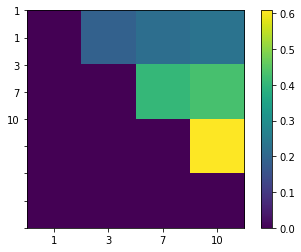

In [42]:
# check new seaborn for heapmap
fig, ax = plt.subplots()

plt.imshow(result)

plt.colorbar()
#labels
column_labels =  [1,1,3,7,10]
row_labels =  [1,1,3,7,10]
ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)

plt.show()

In [43]:
# create dataframe for comparison result and calculate mean, median, and standard deviation
num_list = [str(x) for x in list(range(1,1001))]

df = pd.DataFrame(columns = ['comparison']+num_list)
df['comparison'] = ['1v3', '1v7', '1v10','1v14','3v7','3v10','3v14','7v10','7v14','10v14']
df.set_index(['comparison'],inplace=True)
inverse_dict={0:1,1:3,2:7,3:10}
for i in range(0,4):
    for j in range(0,4):
        if j > i:
            string = str(inverse_dict[i])+'v'+str(inverse_dict[j])
            df.loc[string] = overlap_arr[i][j]
df_copy = df.copy()
df['mean'] = df_copy.mean(axis = 1)
df['median'] = df_copy.median(axis = 1)
df['std'] = df_copy.std(axis=1)
df

/Users/suijialu/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


,1,2,3,4,5,6,7,8,9,10,...,994,995,996,997,998,999,1000,mean,median,std
comparison,,,,,,,,,,,,,,,,,,,,,
1v3,0.21447,0.24677,0.212661,0.2177,0.162791,0.215116,0.203101,0.222222,0.189922,0.196382,...,0.195349,0.193798,0.209561,0.255814,0.225065,0.177003,0.217571,0.205205,0.204393,0.017513
1v7,0.270026,0.23385,0.249354,0.268734,0.258398,0.239018,0.24677,0.22739,0.258398,0.270026,...,0.244186,0.238372,0.264858,0.262274,0.239018,0.244186,0.254522,0.243556,0.242894,0.015305
1v10,0.232558,0.242894,0.273902,0.25323,0.27907,0.226098,0.25969,0.275194,0.248062,0.254522,...,0.211886,0.277778,0.281654,0.264858,0.229974,0.280362,0.237726,0.256279,0.255814,0.015303
1v14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3v7,0.408269,0.381137,0.395349,0.374677,0.409561,0.390181,0.379845,0.375969,0.416021,0.413695,...,0.400517,0.392765,0.397933,0.381137,0.405685,0.395349,0.404393,0.396673,0.396641,0.015932
3v10,0.431525,0.428941,0.413437,0.406977,0.417313,0.406977,0.392765,0.394057,0.410853,0.44186,...,0.422481,0.458656,0.418605,0.436693,0.401809,0.422481,0.400517,0.420537,0.419897,0.014981
3v14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7v10,0.602067,0.581395,0.581395,0.617571,0.594315,0.627907,0.599483,0.586563,0.602067,0.607235,...,0.583979,0.600775,0.599483,0.583979,0.595607,0.596899,0.591731,0.600908,0.600775,0.014012
7v14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
len(food_dict_67)

128

In [45]:
# run distribution of ndays sampling vs baseline
# do not fix k here

def run_distribution(typed,food_dict):
    total_result = []
    df1 = pd.DataFrame(columns = ['ParticipantID','day','overlap'])
    
    newlist = [item for items in  [[x]*4 for x in list(food_dict.keys())] for item in items]
    df1['ParticipantID'] = newlist
    length = len(food_dict)
    df1['day'] = [float(x) for x in ['1','3','7','10']*length]
    #np.repeat()
    
    df1 = df1.sort_index()
    for parID in list(food_dict.keys()):
        percent_arr = []
        for (n_days,k) in zip([1,3,7,10],[3,4,5,7]):
            result = get_random_sample(n_days,parID,typed,k,food_dict)
            percent_arr.append(result)
           
        total_result.append(np.copy(percent_arr))
        
        
    
    overlap_df = np.array(total_result).flatten()

    df1['overlap'] = overlap_df
    result = np.asarray(total_result).mean(axis = 0)
    print(result)

    #plt.figure(figsize=(6, 6))
    #plt.plot([1,3,7,10],result)
    
    sns.lineplot(data=df1, x="day", y="overlap")

    
    return df1
    
    

In [46]:
# run distribution of ndays sampling vs baseline
# use fixed k here
def run_distribution_k(typed,k,food_dict):
    total_result = []
    df1 = pd.DataFrame(columns = ['ParticipantID','day','overlap'])
    
    newlist = [item for items in  [[x]*4 for x in list(food_dict.keys())] for item in items]
    df1['ParticipantID'] = newlist
    length = len(food_dict)
    df1['day'] = [float(x) for x in ['1','3','7','10']*length]
    #np.repeat()
    
    df1 = df1.sort_index()
    for parID in list(food_dict.keys()):
        percent_arr = []
        for n_days in [1,3,7,10]:
            result = get_random_sample(n_days,parID,typed,k,food_dict)
            percent_arr.append(result)
           
        total_result.append(np.copy(percent_arr))
        
        
    
    overlap_df = np.array(total_result).flatten()

    df1['overlap'] = overlap_df
    result = np.asarray(total_result).mean(axis = 0)
    print(result)

    #plt.figure(figsize=(6, 6))
    #plt.plot([1,3,7,10],result)
    
    sns.lineplot(data=df1, x="day", y="overlap").set(title='Overlap score of different sampling method',xlabel='days sampled',ylabel='overlap score')
    

    
    return df1
    
    

[0.28681318 0.44155349 0.63486124 0.73524806]


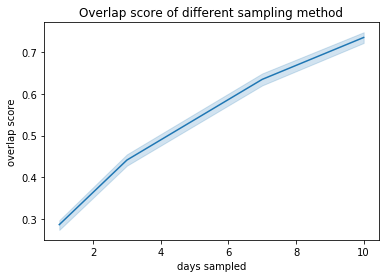

In [47]:
df_ran_fix = run_distribution_k('random',10,food_dict_base)

[0.22062532 0.45089535 0.6531969  0.74321262]


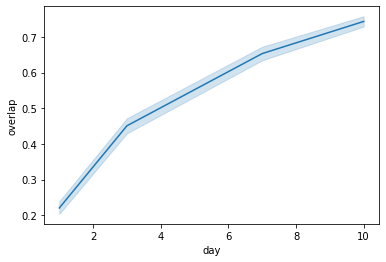

In [48]:
df_ran_nonfix = run_distribution('random',food_dict_base)


In [49]:
df_ran_fix

,ParticipantID,day,overlap
0,9bbi18050005,1.0,0.2293
1,9bbi18050005,3.0,0.3156
2,9bbi18050005,7.0,0.5210
3,9bbi18050005,10.0,0.6205
4,9bbi18050009,1.0,0.3268
...,...,...,...
511,9bbi19120173,10.0,0.7339
512,9bbj18110064,1.0,0.2630
513,9bbj18110064,3.0,0.5674
514,9bbj18110064,7.0,0.7045


In [50]:
df_ran_nonfix

,ParticipantID,day,overlap
0,9bbi18050005,1.0,0.282333
1,9bbi18050005,3.0,0.436000
2,9bbi18050005,7.0,0.562800
3,9bbi18050005,10.0,0.616714
4,9bbi18050009,1.0,0.116000
...,...,...,...
511,9bbi19120173,10.0,0.741714
512,9bbj18110064,1.0,0.294667
513,9bbj18110064,3.0,0.531500
514,9bbj18110064,7.0,0.790600


[0.22055556 0.43835853 0.62900465 0.7292392 ]


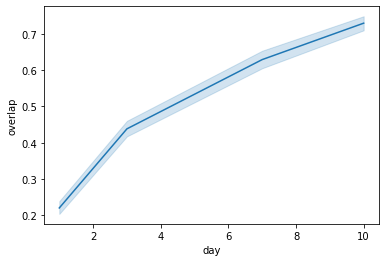

In [51]:
df_conse = run_distribution('consecutive',food_dict_base)

In [52]:
df_conse

,ParticipantID,day,overlap
0,9bbi18050005,1.0,0.285667
1,9bbi18050005,3.0,0.464750
2,9bbi18050005,7.0,0.499600
3,9bbi18050005,10.0,0.472857
4,9bbi18050009,1.0,0.112333
...,...,...,...
511,9bbi19120173,10.0,0.637429
512,9bbj18110064,1.0,0.318333
513,9bbj18110064,3.0,0.623500
514,9bbj18110064,7.0,0.835000


In [53]:
# check how many days of record each participant has
days_for_par = {}
for parID in list(food_dict_all.keys()):
    days_for_par[parID] = len(food_dict_all[parID])
days_for_par = sorted(days_for_par.items(), key=lambda kv: kv[1],reverse=True)
days_for_par


[('9bbi18100060', 384),
 ('9bbi19010071', 379),
 ('9bbi18080049', 369),
 ('9bbi18080047', 363),
 ('9bbi19050121', 352),
 ('9bbi19030090', 351),
 ('9bbi18070037', 348),
 ('9bbi18060018', 339),
 ('9bbi18060028', 336),
 ('9bbi19030095', 325),
 ('9bbi19040105', 325),
 ('9bbi19020076', 324),
 ('9bbi19040114', 324),
 ('9bbi18120067', 321),
 ('9bbi18100062', 318),
 ('9bbi18080050', 313),
 ('9bbi19030093', 313),
 ('9bbi18100061', 311),
 ('9bbi18120070', 307),
 ('9bbi18060034', 305),
 ('9bbi18080051', 300),
 ('9bbi19020077', 298),
 ('9bbi18050009', 271),
 ('9bbi19030094', 267),
 ('9bbi18120071', 265),
 ('9bbi18070039', 260),
 ('9bbi19040104', 259),
 ('9bbi19040112', 259),
 ('9bbi18070044', 257),
 ('9bbi19020074', 254),
 ('9bbi19060133', 251),
 ('9bbi18060013', 249),
 ('9bbi19050116', 249),
 ('9bbi19080143', 249),
 ('9bbi18060020', 248),
 ('9bbi19040109', 247),
 ('9bbi18080048', 243),
 ('9bbi18060021', 242),
 ('9bbi19040097', 241),
 ('9bbi19040110', 241),
 ('9bbi19020075', 240),
 ('9bbi19040107'

## Overlap score for each individual

In [54]:
df_baseline = df_index[df_index['group']=='baseline']

In [55]:
# overlap score for a selected individual during baseline
def overlap_par(parID,n_days,df,food_dict):
    df_par = df.query('ParticipantID == @parID')
    unique_food = df_par['Parsed food'].unique()
    sample = random_sample(n_days,parID,food_dict)
    unique_sample = np.unique(sample)
    return len(unique_sample)/len(unique_food)
    
    
    
    
    

In [56]:
overlap_par('9bbi19060129',10,df_baseline,food_dict_base)

0.7662337662337663

In [57]:
# plot the distribution of the overlap scores from 1-10 days
# Question: do we need to repeat 1000 times?
def plot_overlap_distribution(parID,df,food_dict):
    x = list(range(1,11))
    overlap = []
    for i in range(1,11):
        overlap.append(overlap_par(parID,i,df,food_dict))
    plt.plot(x,overlap)
    plt.xlabel('days sampled')
    plt.xticks(x)
    plt.ylabel('overlap score')
    plt.title('Unique food item overlap between samples and baseline')
    print(overlap)
    
        
        
        

[0.18181818181818182, 0.22077922077922077, 0.2727272727272727, 0.37662337662337664, 0.45454545454545453, 0.5454545454545454, 0.6103896103896104, 0.7012987012987013, 0.7272727272727273, 0.7402597402597403]


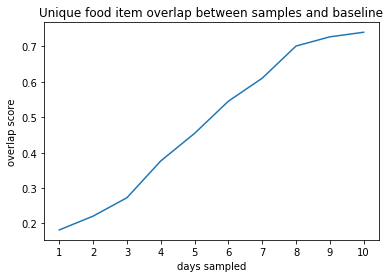

In [58]:
plot_overlap_distribution('9bbi19060129',df_baseline,food_dict_base)

In [59]:
# plot the distribution of the overlap scores from 1-10 days and average over 1000 repetitions
def plot_overlap_distribution2(parID,df,food_dict):
    x = list(range(1,11))
    repetition = []
    for j in range(1000):
        overlap = []
        for i in range(1,11):
            overlap.append(overlap_par(parID,i,df,food_dict))
        repetition.append(np.copy(overlap))
    result = np.mean(repetition,axis=0)
    # use 95 confidence interval sns.plot
    plt.plot(x,result)
    plt.xlabel('days sampled')
    plt.xticks(x)
    plt.ylabel('overlap score')
    plt.title('Unique food item overlap between samples and baseline for 1000 times')
    print(result)
    

    

[0.11675325 0.21957143 0.30894805 0.39494805 0.46815584 0.54535065
 0.60680519 0.67057143 0.72674026 0.77955844]


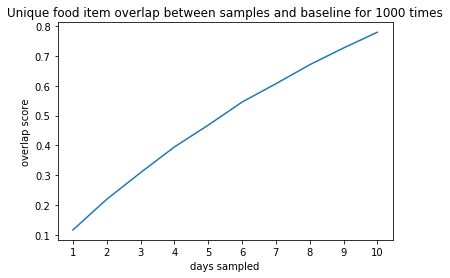

In [60]:
plot_overlap_distribution2('9bbi19060129',df_baseline,food_dict_base)

## Diversity Analysis

In [61]:
df

,1,2,3,4,5,6,7,8,9,10,...,994,995,996,997,998,999,1000,mean,median,std
comparison,,,,,,,,,,,,,,,,,,,,,
1v3,0.21447,0.24677,0.212661,0.2177,0.162791,0.215116,0.203101,0.222222,0.189922,0.196382,...,0.195349,0.193798,0.209561,0.255814,0.225065,0.177003,0.217571,0.205205,0.204393,0.017513
1v7,0.270026,0.23385,0.249354,0.268734,0.258398,0.239018,0.24677,0.22739,0.258398,0.270026,...,0.244186,0.238372,0.264858,0.262274,0.239018,0.244186,0.254522,0.243556,0.242894,0.015305
1v10,0.232558,0.242894,0.273902,0.25323,0.27907,0.226098,0.25969,0.275194,0.248062,0.254522,...,0.211886,0.277778,0.281654,0.264858,0.229974,0.280362,0.237726,0.256279,0.255814,0.015303
1v14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3v7,0.408269,0.381137,0.395349,0.374677,0.409561,0.390181,0.379845,0.375969,0.416021,0.413695,...,0.400517,0.392765,0.397933,0.381137,0.405685,0.395349,0.404393,0.396673,0.396641,0.015932
3v10,0.431525,0.428941,0.413437,0.406977,0.417313,0.406977,0.392765,0.394057,0.410853,0.44186,...,0.422481,0.458656,0.418605,0.436693,0.401809,0.422481,0.400517,0.420537,0.419897,0.014981
3v14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7v10,0.602067,0.581395,0.581395,0.617571,0.594315,0.627907,0.599483,0.586563,0.602067,0.607235,...,0.583979,0.600775,0.599483,0.583979,0.595607,0.596899,0.591731,0.600908,0.600775,0.014012
7v14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
df_temp = df_index.query('ParticipantID == "9bbi18050005" and DayPassed <= 14' )
df_temp['Parsed food'].unique()


array(['gatorade', 'shrimp taco', 'coke', 'granola bar', 'yogurt',
       'egg burrito', 'sausage', 'grapefruit', 'pizza',
       'coffee cream sugar', 'fruit', 'lemon', 'chile', 'ice cream',
       'steak egg', 'cheese', 'potato', 'burrito', 'coffee creamer',
       'banana', 'iced coffee cream', 'taco salad', 'watermelon', 'bagel',
       'shrimp burrito', 'salsa', 'beer', 'carne asada', 'nacho',
       'spinach', 'avocado', 'bacon', 'mango', 'orange', 'melon',
       'peanut butter', 'walnut', 'salad', 'wine', 'chocolate cake',
       'caprese', 'salami', 'cracker', 'pear', 'margarita', 'beef', 'rib',
       'coleslaw', 'bbq', 'bean', 'hash brown', 'chorizo', 'taco',
       'pita chip', 'cinnamon', 'fried chicken', 'broccoli',
       'iced coffee', 'carne asada burrito', 'tuna sandwich', 'sourdough',
       'celery', 'chip', 'pork rib', 'corn', 'asparagus', 'egg',
       'orange juice', 'donut', 'breakfast burrito', 'milk', 'gummies',
       'brisket', 'sandwich', 'chicken caesar sa

Text(0, 0.5, 'frequency')

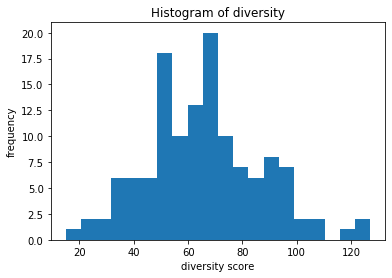

In [63]:
# calculate diversity of each participant in first 14 days 
# diversity: unique food items participants ate
diversity = {}
for parID in food_dict_base.keys():
    df_temp = df_index.query('ParticipantID == @parID and DayPassed <= 14' )
    unique_food_num = len(df_temp['Parsed food'].unique())
    diversity[parID] = unique_food_num
diversity_value = diversity.values()    
_ = plt.hist(diversity_value, bins=20)
plt.title("Histogram of diversity")
plt.xlabel("diversity score")
plt.ylabel("frequency")

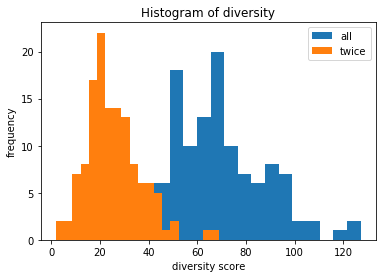

In [64]:
# calculate diversity of each participant in first 14 days 
# diversity: unique food items participants ate for at least twice
diversity = {}
for parID in food_dict_base.keys():
    df_temp = df_index.query('ParticipantID == @parID and DayPassed <= 14' )
    unique_food_num = len(df_temp['Parsed food'].unique())
    diversity[parID] = unique_food_num
diversity_value = diversity.values()    
_ = plt.hist(diversity_value, bins=20,label='all')
plt.title("Histogram of diversity")
plt.xlabel("diversity score")
plt.ylabel("frequency")

diversity = {}
for parID in food_dict_base.keys():
    df_temp = df_index.query('ParticipantID == @parID and DayPassed <= 14' )
    unique_food = df_temp['Parsed food'].value_counts()
    unique_food_twice = []
    for index, value in unique_food.items():
        if value>=2:
            unique_food_twice.append(index)
    diversity[parID] = len(unique_food_twice)
diversity_value = diversity.values()    
_ = plt.hist(diversity_value, bins=20,label='twice')
plt.title("Histogram of diversity")
plt.xlabel("diversity score")
plt.ylabel("frequency")
plt.legend()

In [65]:
# days of record for baseline
days_for_par = {}
for parID in list(food_dict_base.keys()):
    days_for_par[parID] = len(food_dict_base[parID])
days_for_par = sorted(days_for_par.items(), key=lambda kv: kv[1],reverse=True)
days_for_par



[('9bbi18050005', 15),
 ('9bbi18050009', 15),
 ('9bbi18050011', 15),
 ('9bbi18060014', 15),
 ('9bbi18060018', 15),
 ('9bbi18060020', 15),
 ('9bbi18060029', 15),
 ('9bbi18060031', 15),
 ('9bbi18060034', 15),
 ('9bbi18060035', 15),
 ('9bbi18060036', 15),
 ('9bbi18070037', 15),
 ('9bbi18070038', 15),
 ('9bbi18070039', 15),
 ('9bbi18070041', 15),
 ('9bbi18070042', 15),
 ('9bbi18070043', 15),
 ('9bbi18070044', 15),
 ('9bbi18070045', 15),
 ('9bbi18080047', 15),
 ('9bbi18080048', 15),
 ('9bbi18080049', 15),
 ('9bbi18080050', 15),
 ('9bbi18080051', 15),
 ('9bbi18090053', 15),
 ('9bbi18090056', 15),
 ('9bbi18090057', 15),
 ('9bbi18090058', 15),
 ('9bbi18100060', 15),
 ('9bbi18100061', 15),
 ('9bbi18100062', 15),
 ('9bbi18100063', 15),
 ('9bbi18120067', 15),
 ('9bbi18120068', 15),
 ('9bbi18120071', 15),
 ('9bbi19010071', 15),
 ('9bbi19020074', 15),
 ('9bbi19020076', 15),
 ('9bbi19020077', 15),
 ('9bbi19020078', 15),
 ('9bbi19020081', 15),
 ('9bbi19020082', 15),
 ('9bbi19030086', 15),
 ('9bbi1903

In [66]:
a = [1,2,3,4]
a[-1]

4

In [67]:
def extract_diversity(parID,food_dict):
    diversity = []
    unique_food = []
    par_dict = food_dict[parID]
    for day,foods in par_dict.items():
        unique_food += foods
        diversity.append(len(np.unique(unique_food)))
    if len(diversity) < 15:
        for i in range(15-len(diversity)):
            diversity.append(diversity[-1])
    return diversity
        
    

In [68]:
diver = extract_diversity('9bbi18060017',food_dict_base)

In [69]:
def plot_diversity_line(food_dict):
    plt.figure(figsize=(20,10))
    for par in food_dict.keys():
        diversity = extract_diversity(par,food_dict)
        plt.plot(diversity,marker='.')
        plt.xlabel('sampled days')
        plt.ylabel('diversity')
    plt.show()

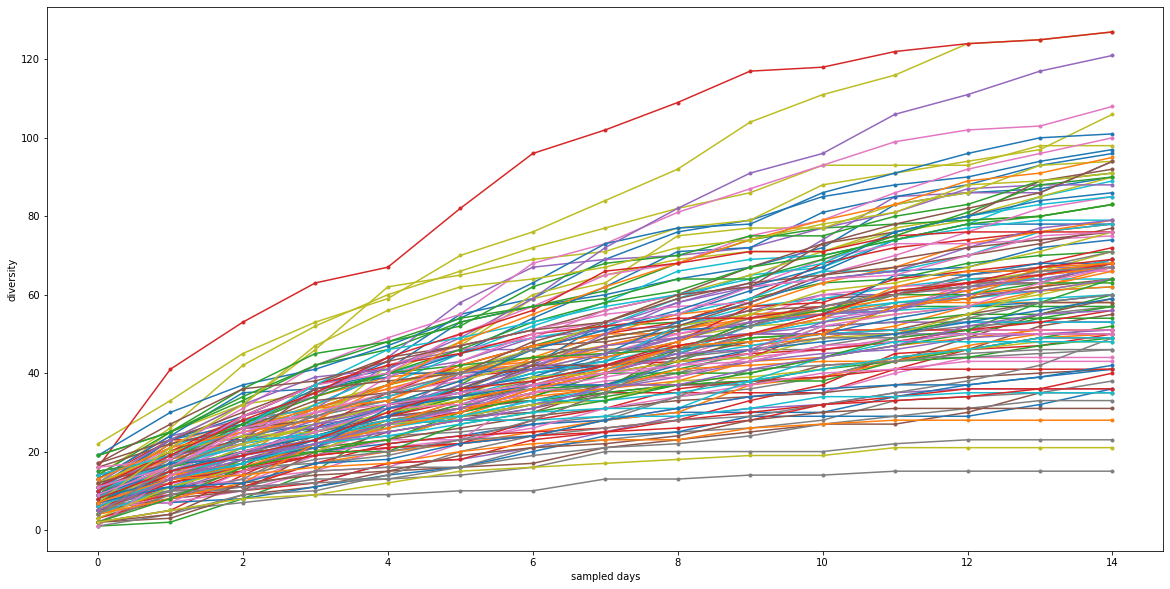

In [70]:
plot_diversity_line(food_dict_base)

## Diversity distribution vs Cumulative diversity plot

In [71]:
df_diversity = pd.Series(diversity).to_frame()
df_diversity.rename({0:'diversity'}, axis='columns',inplace=True)
df_diversity.sort_values(by=['diversity'],inplace=True)
df_diversity.reset_index(inplace=True)
df_diversity.rename({'index':'ParticipantID'}, axis='columns',inplace=True)

In [72]:
df_diversity

,ParticipantID,diversity
0,9bbi19060133,2
1,9bbi19100165,5
2,9bbi19100158,7
3,9bbj18110064,8
4,9bbi18070044,9
...,...,...
124,9bbi18090058,47
125,9bbi19030086,49
126,9bbi19050128,49
127,9bbi19040113,63


In [73]:
df_diversity2 = df_diversity.copy()
col = 'diversity'
q = df_diversity2.quantile([0.00, 0.25, 0.50, 0.75, 1.00])
df_diversity2['quartile'] = np.where(
    ((df_diversity2[col]>=q[col][0.00]) & (df_diversity2[col]<q[col][0.25])), 0.25, np.where(
    ((df_diversity2[col]>=q[col][0.25]) & (df_diversity2[col]<q[col][0.50])), 0.50, 
        np.where(((df_diversity2[col]>=q[col][0.50]) & (df_diversity2[col]<q[col][0.75])),0.75,1.00))) 


In [74]:
df_diversity2

,ParticipantID,diversity,quartile
0,9bbi19060133,2,0.25
1,9bbi19100165,5,0.25
2,9bbi19100158,7,0.25
3,9bbj18110064,8,0.25
4,9bbi18070044,9,0.25
...,...,...,...
124,9bbi18090058,47,1.00
125,9bbi19030086,49,1.00
126,9bbi19050128,49,1.00
127,9bbi19040113,63,1.00


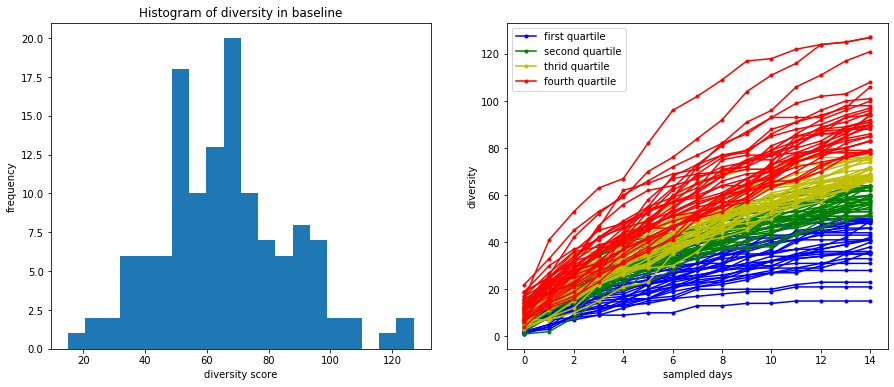

In [75]:
# calculate diversity of each participant in first 14 days 
# diversity: unique food items participants ate
diversity_base = {}
for parID in food_dict_base.keys():
    df_temp = df_index.query('ParticipantID == @parID and DayPassed <= 14' )
    unique_food_num = len(df_temp['Parsed food'].unique())
    diversity_base[parID] = unique_food_num
diversity_value_base = diversity_base.values()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(diversity_value_base, bins=20)
ax1.set_title("Histogram of diversity in baseline")
ax1.set_xlabel("diversity score")
ax1.set_ylabel("frequency")

df_diversity = pd.Series(diversity_base).to_frame()
df_diversity.rename({0:'diversity'}, axis='columns',inplace=True)
df_diversity.sort_values(by=['diversity'],inplace=True)
df_diversity.reset_index(inplace=True)
df_diversity.rename({'index':'ParticipantID'}, axis='columns',inplace=True)
df_diversity2 = df_diversity.copy()
col = 'diversity'
q = df_diversity2.quantile([0.00, 0.25, 0.50, 0.75, 1.00])
df_diversity2['quartile'] = np.where(
    ((df_diversity2[col]>=q[col][0.00]) & (df_diversity2[col]<q[col][0.25])), 0.25, np.where(
    ((df_diversity2[col]>=q[col][0.25]) & (df_diversity2[col]<q[col][0.50])), 0.50, 
        np.where(((df_diversity2[col]>=q[col][0.50]) & (df_diversity2[col]<q[col][0.75])),0.75,1.00))) 

# line plot
color = ['b','g','y','r']
for quartile,c,l in zip([0.25, 0.50, 0.75, 1.00],color,['first quartile','second quartile','thrid quartile','fourth quartile']):
    group = df_diversity2[df_diversity2['quartile']==quartile]['ParticipantID']    
    count = 0
    for par in group:
        diversity = extract_diversity(par,food_dict_base)
        if count == 0:
            ax2.plot(diversity,marker='.',color=c,label=l)
        else:
            ax2.plot(diversity,marker='.',color=c)
        count+=1

ax2.set_xlabel('sampled days')
ax2.set_ylabel('diversity')
ax2.legend()



In [76]:
def plot_diversity_quartile(food_dict,df):
    plt.figure(figsize=(20,10))
    color = ['b','g','y','r']

    for quartile,c,l in zip([0.25, 0.50, 0.75, 1.00],color,['first quartile','second quartile','thrid quartile','fourth quartile']):
        group = df[df['quartile']==quartile]['ParticipantID']    
        count = 0
        for par in group:
            diversity = extract_diversity(par,food_dict)
            if count == 0:
                plt.plot(diversity,marker='.',color=c,label=l)
            else:
                plt.plot(diversity,marker='.',color=c)
            count+=1
 
    plt.xlabel('sampled days')
    plt.ylabel('diversity')
    plt.legend()
    plt.show()

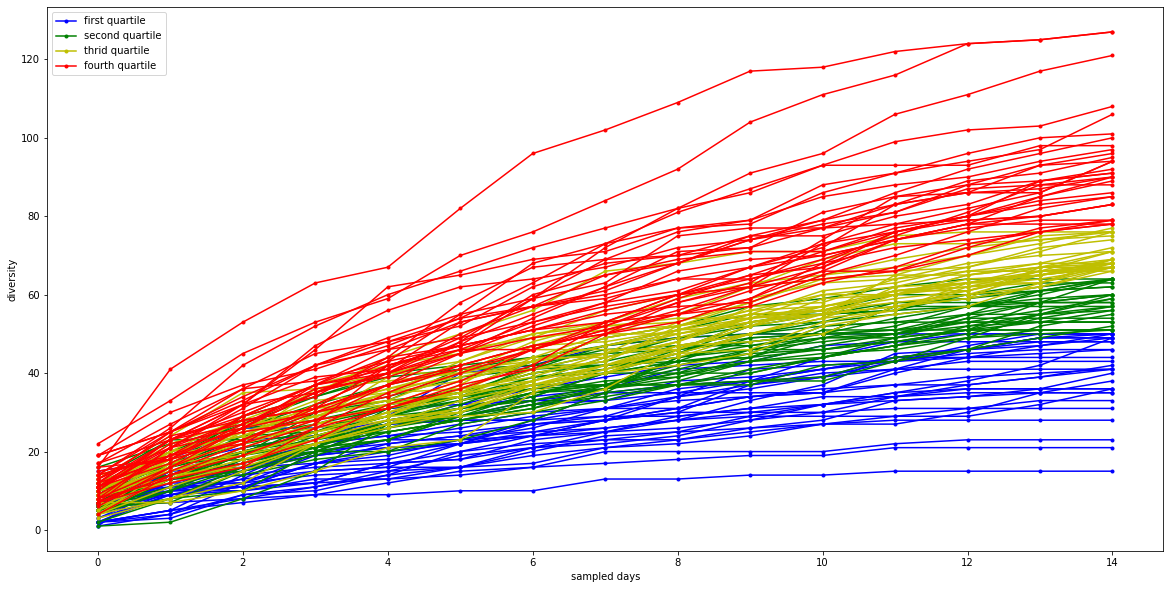

In [77]:
plot_diversity_quartile(food_dict_base,df_diversity2)

In [78]:
# extract 5 participants of low, middle and high diversity
low_diversity = df_diversity[:5]
middle_diversity = df_diversity[62:67]
high_diversity = df_diversity[124:]
low_id = np.array(low_diversity['ParticipantID'])
mid_id = np.array(middle_diversity['ParticipantID'])
high_id = np.array(high_diversity['ParticipantID'])

In [79]:
middle_diversity

,ParticipantID,diversity
62,9bbi18060020,64
63,9bbi18060021,64
64,9bbi18060030,66
65,9bbi18100062,66
66,9bbi18070043,67


In [80]:
# for each people, generate a histogram, np.unique (return counts and sort), divide by the sum of food items; x axis: unique food items
# seaborn, histogram, density plot; facetgrid want all have the same y axis
# matplotshare y == true
# lowest 5, middle 5, highest 5

In [81]:
df_baseline

Time             Logged entry  \
ParticipantID Date                                             
9bbi18050005  2018-05-08  18.016667           gatorade 16 oz   
              2018-05-08  19.083333    2 grilled shrim tacos   
              2018-05-08  19.100000                   1 coke   
              2018-05-08  12.900000              granola bar   
              2018-05-08  11.650000              granola bar   
...                             ...                      ...   
9bbj18110064  2018-12-20  18.250000            tofu stir fry   
              2018-12-20  12.250000  chicken burrito and avo   
              2018-12-20  12.250000  chicken burrito and avo   
              2018-12-20   8.500000        pancakes and eggs   
              2018-12-20   8.500000        pancakes and eggs   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
9bbj18110064  2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   

                              Parsed food  DayPassed     group  
ParticipantID Date                                              
9bbi18050005  2018-05-08         gatorade          0  baseline  
              2018-05-08      shrimp taco          0  baseline  
              2018-05-08             coke          0  baseline  
              2018-05-08      granola bar          0  baseline  
              2018-05-08      granola bar          0  baseline  
...                                   ...        ...       ...  
9bbj18110064  2018-12-20             tofu         14  baseline  
              2018-12-20  chicken burrito         14  baseline  
              2018-12-20          avocado         14  baseline  
              2018-12-20          pancake         14  baseline  
              2018-12-20              egg         14  baseline  

[17211 rows x 6 columns]

In [82]:
df_index.query(' group == "baseline"')

Time             Logged entry  \
ParticipantID Date                                             
9bbi18050005  2018-05-08  18.016667           gatorade 16 oz   
              2018-05-08  19.083333    2 grilled shrim tacos   
              2018-05-08  19.100000                   1 coke   
              2018-05-08  12.900000              granola bar   
              2018-05-08  11.650000              granola bar   
...                             ...                      ...   
9bbj18110064  2018-12-20  18.250000            tofu stir fry   
              2018-12-20  12.250000  chicken burrito and avo   
              2018-12-20  12.250000  chicken burrito and avo   
              2018-12-20   8.500000        pancakes and eggs   
              2018-12-20   8.500000        pancakes and eggs   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
9bbj18110064  2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   

                              Parsed food  DayPassed     group  
ParticipantID Date                                              
9bbi18050005  2018-05-08         gatorade          0  baseline  
              2018-05-08      shrimp taco          0  baseline  
              2018-05-08             coke          0  baseline  
              2018-05-08      granola bar          0  baseline  
              2018-05-08      granola bar          0  baseline  
...                                   ...        ...       ...  
9bbj18110064  2018-12-20             tofu         14  baseline  
              2018-12-20  chicken burrito         14  baseline  
              2018-12-20          avocado         14  baseline  
              2018-12-20          pancake         14  baseline  
              2018-12-20              egg         14  baseline  

[17211 rows x 6 columns]

In [83]:
# method to generate dictionary used to plot participant's diet diversity
def generate_div(parID,typed,df):
    if typed == 'all':
        a=np.array(df.query('ParticipantID==@parID')['Parsed food'])
        total_num = len(a)
        values, counts=np.unique(a,return_counts=True)
        div_dict = dict(zip(values,counts))
        div = dict(sorted(div_dict.items(), key=lambda x: x[1], reverse=True))
        return div,total_num
    if typed == 'twice':
        unique_food = df.query('ParticipantID==@parID')['Parsed food'].value_counts()
        unique_food_twice = {}
        total_num = 0
        for index, value in unique_food.items():
            if value>=2:
                unique_food_twice[index]=value
                total_num += value
        
        #total_num = len(unique_food_twice)

        div_dict = unique_food_twice
        div = dict(sorted(div_dict.items(), key=lambda x: x[1], reverse=True))
        return div,total_num
        
    

In [84]:
# method to generate dictionary with food items which appears more than once
def generate_div2(parID,df):
    
    a=np.array(df.query('ParticipantID==@parID')['Parsed food'])
    diversity = len(df.query('ParticipantID==@parID')['Parsed food'].unique())
    total_num = len(a)
    values, counts=np.unique(a,return_counts=True)
    div_dict = dict(zip(values,counts))
    div = dict(sorted(div_dict.items(), key=lambda x: x[1], reverse=True))
    div_subset = {key: value for key, value in div.items() if value > 1}

    return div_subset,total_num,diversity

Plot diversity barplot for the top5, middle5, and lowest 5 participants w.r.t their food diversity

X-axis indicates unique food items appeared in a person's diet, which is neglected for better visualization

Y-axis indicates density of each food item

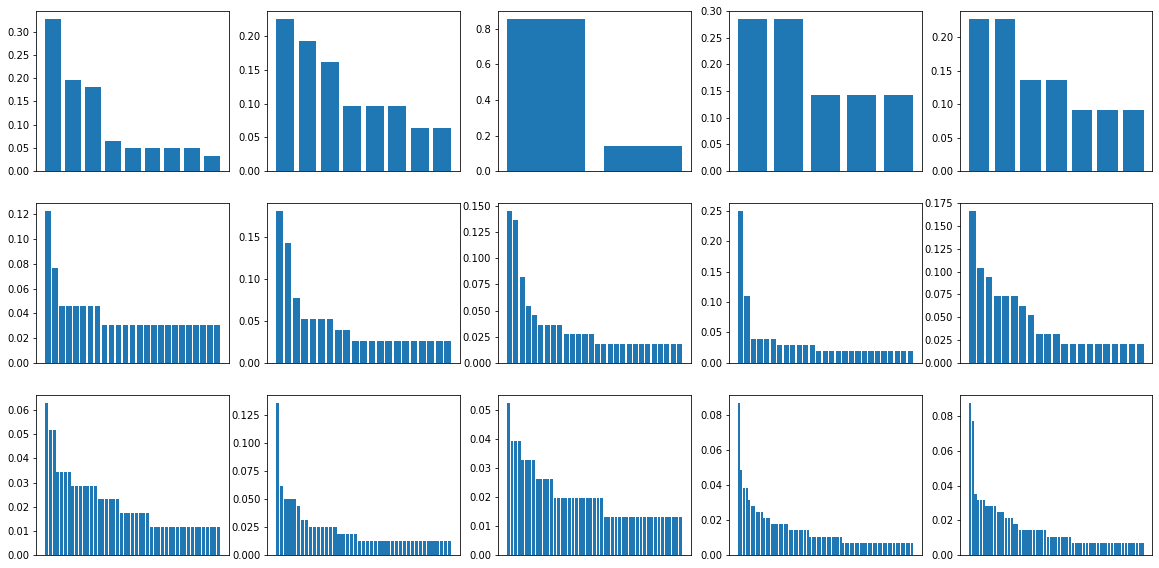

In [85]:
plt.figure(figsize=(20,10))
num_plot = 1
#low diversity
for parID in low_id:
    div,total_num = generate_div(parID,'twice',df_baseline)
    plt.subplot(3,5,num_plot)
    plt.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks([])
    #axes[num_plot].set_xlabel("")
    num_plot +=1
#middle diversity
for parID in mid_id:
    div,total_num = generate_div(parID,'twice',df_baseline)
    plt.subplot(3,5,num_plot)
    plt.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks([])
    num_plot +=1
#high diversity
for parID in high_id:
    div,total_num = generate_div(parID,'twice',df_baseline)
    plt.subplot(3,5,num_plot)
    plt.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks([])
    num_plot +=1



Shared Y version of the above plot

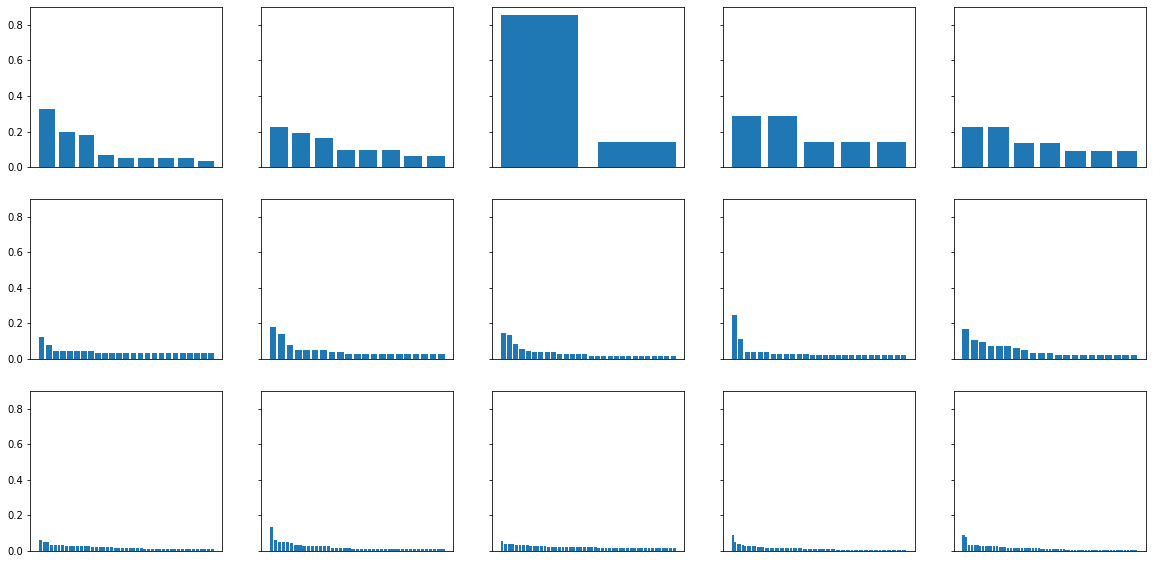

In [86]:

fig, ((ax1, ax2,ax3,ax4,ax5), (ax6, ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3, 5,sharey=True,figsize=(20,10))
num_plot = 1
for parID,ax in zip(low_id,[ax1,ax2,ax3,ax4,ax5]):
    div,total_num = generate_div(parID,'twice',df_baseline)
    
 
    ax.bar(div.keys(), [x/total_num for x in div.values()])
    ax.set_xticks([])
    num_plot +=1
for (parID,ax) in zip(mid_id,[ax6, ax7,ax8,ax9,ax10]):
    div,total_num = generate_div(parID,'twice',df_baseline)

    ax.bar(div.keys(), [x/total_num for x in div.values()])
    ax.set_xticks([])
    num_plot +=1
for (parID,ax) in zip(high_id,[ax11,ax12,ax13,ax14,ax15]):
    div,total_num = generate_div(parID,'twice',df_baseline)

    ax.bar(div.keys(), [x/total_num for x in div.values()])
    ax.set_xticks([])
    num_plot +=1




In [87]:
#visualize diveristy: denote number of unique items; display food name vertical; limit: frequency 1

In [88]:
#Plot diversity barplot for each individual. For better visualization, we exclude food item that appeared only once

#X-axis indicates unique food items appeared in a person's diet, which is neglected for better visualization

#Y-axis indicates density of each food item
def visualize_diversity(parID,df):
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    div,total_num,diversity = generate_div2(parID,df)
    ax.text(0.9,0.9,f'Diversity: {diversity}', horizontalalignment='center',verticalalignment='center',transform = ax.transAxes,fontsize=20)
    ax.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks(rotation='vertical')
    plt.xlabel('food item')
    plt.ylabel('food density')
    
    plt.show()
    


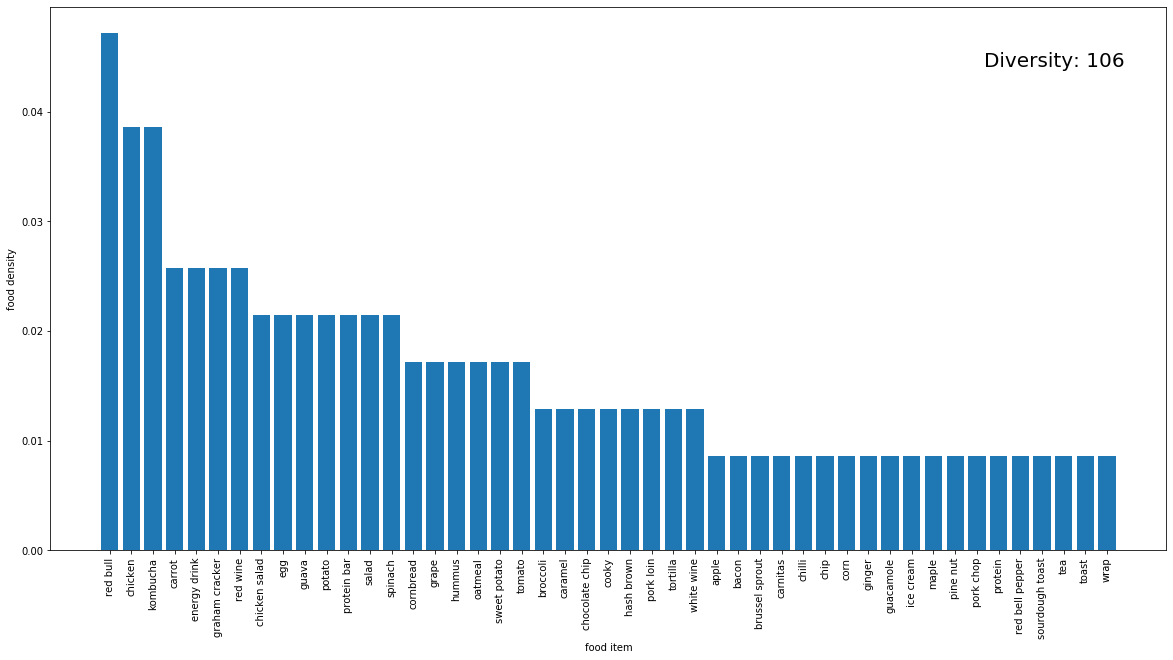

In [89]:
#participant from high-diversity group
visualize_diversity('9bbi18090058',df_baseline)

In [90]:
# participant from middle-diversity group 
visualize_diversity('9bbi18060020')

TypeError: visualize_diversity() missing 1 required positional argument: 'df'

In [ ]:
# participant from low diversity group
visualize_diversity('9bbi18070044')

In [ ]:
# participant with only diversity 2
visualize_diversity('9bbi19060133')

## Fit exponential plots

In [92]:
df_intervention = df_index.query('group == "intervention"')

In [93]:
df_intervention

Time                     Logged entry  \
ParticipantID Date                                                     
9bbi18050005  2018-05-23   8.683333          cup of coffee w creamer   
              2018-05-23  18.416667     spinach salad with white and   
              2018-05-23  18.416667    brown rice shrimp and octopus   
              2018-05-23  18.416667    brown rice shrimp and octopus   
              2018-05-23  18.416667   sauted in lemon white wine say   
...                             ...                              ...   
9bbj18110064  2019-12-18  17.750000                       meat pasta   
              2019-12-18  17.750000                       meat pasta   
              2019-12-18  12.750000                  turkey sandwich   
              2019-12-18   9.000000                          oatmeal   
              2019-12-18  22.800000                          cooffee   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-23                                          b   
              2018-05-23                                          f   
              2018-05-23                                          f   
              2018-05-23                                          f   
              2018-05-23                                          b   
...                                                             ...   
9bbj18110064  2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          b   

                              Parsed food  DayPassed         group  
ParticipantID Date                                                  
9bbi18050005  2018-05-23   coffee creamer         15  intervention  
              2018-05-23    spinach salad         15  intervention  
              2018-05-23       brown rice         15  intervention  
              2018-05-23           shrimp         15  intervention  
              2018-05-23       white wine         15  intervention  
...                                   ...        ...           ...  
9bbj18110064  2019-12-18             meat        377  intervention  
              2019-12-18            pasta        377  intervention  
              2019-12-18  turkey sandwich        377  intervention  
              2019-12-18          oatmeal        377  intervention  
              2019-12-18           coffee        377  intervention  

[166881 rows x 6 columns]

In [94]:
df_intervention.query('ParticipantID == "9bbi18050005"')['DayPassed'].unique()[49]

66

In [95]:
df_inter_50 = df_intervention.query('DayPassed <= 50')
for par in df_inter_50.reset_index()['ParticipantID'].unique():
    num = len(df_inter_50.query('ParticipantID == @par')['DayPassed'].unique())
    print(par,f' has {num} days of record')

9bbi18050005  has 35 days of record
9bbi18050009  has 35 days of record
9bbi18050011  has 35 days of record
9bbi18060012  has 35 days of record
9bbi18060013  has 36 days of record
9bbi18060014  has 33 days of record
9bbi18060017  has 18 days of record
9bbi18060018  has 35 days of record
9bbi18060020  has 35 days of record
9bbi18060021  has 26 days of record
9bbi18060022  has 21 days of record
9bbi18060023  has 35 days of record
9bbi18060024  has 35 days of record
9bbi18060027  has 26 days of record
9bbi18060028  has 36 days of record
9bbi18060029  has 34 days of record
9bbi18060030  has 36 days of record
9bbi18060031  has 36 days of record
9bbi18060034  has 35 days of record
9bbi18060035  has 32 days of record
9bbi18060036  has 35 days of record
9bbi18070037  has 36 days of record
9bbi18070038  has 24 days of record
9bbi18070039  has 36 days of record
9bbi18070041  has 29 days of record
9bbi18070042  has 32 days of record
9bbi18070043  has 32 days of record
9bbi18070044  has 36 days of

In [96]:

for par in df_intervention.reset_index()['ParticipantID'].unique():
    num = len(df_intervention.query('ParticipantID == @par')['DayPassed'].unique())
    if num < 50:
        print(par,f' has {num} days of record')

9bbi19030086  has 43 days of record
9bbi19090144  has 49 days of record
9bbi19100158  has 49 days of record


In [97]:
#extract 50 logging days
index = 0
for par in df_intervention.reset_index()['ParticipantID'].unique():
    if len(df_intervention.query('ParticipantID == @par')['DayPassed'].unique()) >= 50:
        log_50s = df_intervention.query('ParticipantID == @par')['DayPassed'].unique()[49]
        if (index != 0):
            df_temp = df_intervention.query('ParticipantID == @par and DayPassed <= @log_50s')
            df_log = pd.concat([df_log, df_temp])
        else:
            df_log = df_intervention.query('ParticipantID == @par and DayPassed <= @log_50s')
        index+=1
    

In [98]:
len(df_log.query('ParticipantID == "9bbj18110064"')['DayPassed'].unique())

50

In [99]:
df_log

Time                     Logged entry  \
ParticipantID Date                                                     
9bbi18050005  2018-05-23   8.683333          cup of coffee w creamer   
              2018-05-23  18.416667     spinach salad with white and   
              2018-05-23  18.416667    brown rice shrimp and octopus   
              2018-05-23  18.416667    brown rice shrimp and octopus   
              2018-05-23  18.416667   sauted in lemon white wine say   
...                             ...                              ...   
9bbj18110064  2019-04-14  12.400000             lentil wrap with avo   
              2019-04-14  12.400000             lentil wrap with avo   
              2019-04-14  12.400000             lentil wrap with avo   
              2019-04-14   9.400000                pancakes and eggs   
              2019-04-14   9.400000                pancakes and eggs   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-23                                          b   
              2018-05-23                                          f   
              2018-05-23                                          f   
              2018-05-23                                          f   
              2018-05-23                                          b   
...                                                             ...   
9bbj18110064  2019-04-14                                          f   
              2019-04-14                                          f   
              2019-04-14                                          f   
              2019-04-14                                          f   
              2019-04-14                                          f   

                             Parsed food  DayPassed         group  
ParticipantID Date                                                 
9bbi18050005  2018-05-23  coffee creamer         15  intervention  
              2018-05-23   spinach salad         15  intervention  
              2018-05-23      brown rice         15  intervention  
              2018-05-23          shrimp         15  intervention  
              2018-05-23      white wine         15  intervention  
...                                  ...        ...           ...  
9bbj18110064  2019-04-14          lentil        129  intervention  
              2019-04-14            wrap        129  intervention  
              2019-04-14         avocado        129  intervention  
              2019-04-14         pancake        129  intervention  
              2019-04-14             egg        129  intervention  

[47548 rows x 6 columns]

In [100]:
#make food log for 50 logging days in intervention period

food_dict_log= {}
for par in df_log.reset_index()['ParticipantID'].unique():
    food_dict_log[par] = {}
    
    df_temp = df_log.query('ParticipantID == @par')
    df_temp.reset_index(inplace=True)
    dates = df_temp['Date'].unique()
    for date in dates:
        df_temp2 = df_temp.query('Date == @date')
    
        for index, value in df_temp2['Parsed food'].iteritems():
            if date not in food_dict_log[par].keys():
                food_dict_log[par][date] = [value]
            else:
                 food_dict_log[par][date].append(value)

In [101]:

#make food log for 100 logging days in intervention period

#extract 100 logging days
index = 0
for par in df_intervention.reset_index()['ParticipantID'].unique():
    if len(df_intervention.query('ParticipantID == @par')['DayPassed'].unique()) >= 100:
        log_100s = df_intervention.query('ParticipantID == @par')['DayPassed'].unique()[99]
        if (index != 0):
            df_temp = df_intervention.query('ParticipantID == @par and DayPassed <= @log_100s')
            df_log2 = pd.concat([df_log2, df_temp])
        else:
            df_log2 = df_intervention.query('ParticipantID == @par and DayPassed <= @log_100s')
        index+=1
        
food_dict_log2= {}
for par in df_log2.reset_index()['ParticipantID'].unique():
    food_dict_log2[par] = {}
    
    df_temp = df_log2.query('ParticipantID == @par')
    df_temp.reset_index(inplace=True)
    dates = df_temp['Date'].unique()
    for date in dates:
        df_temp2 = df_temp.query('Date == @date')
    
        for index, value in df_temp2['Parsed food'].iteritems():
            if date not in food_dict_log2[par].keys():
                food_dict_log2[par][date] = [value]
            else:
                 food_dict_log2[par][date].append(value)

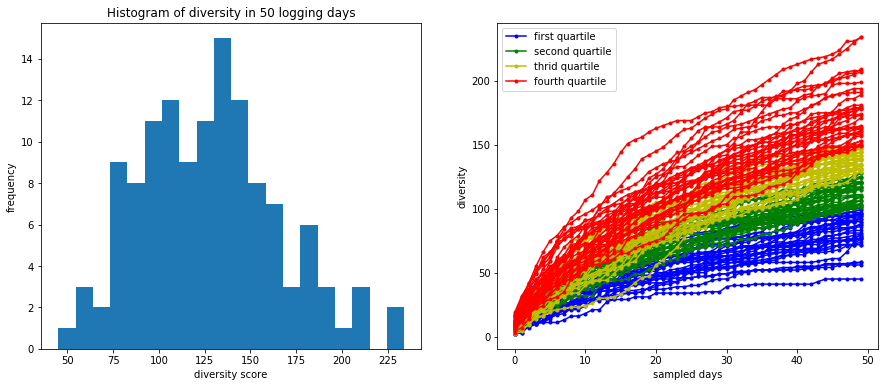

In [102]:
diversity_log = {}
for parID in df_log.reset_index()['ParticipantID'].unique():
    df_temp = df_log.query('ParticipantID == @parID' )
    unique_food_num = len(df_temp['Parsed food'].unique())
    diversity_log[parID] = unique_food_num
diversity_value_log = diversity_log.values()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(diversity_value_log, bins=20)
ax1.set_title("Histogram of diversity in 50 logging days")
ax1.set_xlabel("diversity score")
ax1.set_ylabel("frequency")

df_diversity_log = pd.Series(diversity_log).to_frame()
df_diversity_log.rename({0:'diversity'}, axis='columns',inplace=True)
df_diversity_log.sort_values(by=['diversity'],inplace=True)
df_diversity_log.reset_index(inplace=True)
df_diversity_log.rename({'index':'ParticipantID'}, axis='columns',inplace=True)

col = 'diversity'
q = df_diversity_log.quantile([0.00, 0.25, 0.50, 0.75, 1.00])
df_diversity_log['quartile'] = np.where(
    ((df_diversity_log[col]>=q[col][0.00]) & (df_diversity_log[col]<q[col][0.25])), 0.25, np.where(
    ((df_diversity_log[col]>=q[col][0.25]) & (df_diversity_log[col]<q[col][0.50])), 0.50, 
        np.where(((df_diversity_log[col]>=q[col][0.50]) & (df_diversity_log[col]<q[col][0.75])),0.75,1.00))) 
# line plot
color = ['b','g','y','r']
for quartile,c,l in zip([0.25, 0.50, 0.75, 1.00],color,['first quartile','second quartile','thrid quartile','fourth quartile']):
    group = df_diversity_log[df_diversity_log['quartile']==quartile]['ParticipantID']    
    count = 0
    for par in group:
        diversity = extract_diversity(par,food_dict_log)
        if count == 0:
            ax2.plot(diversity,marker='.',color=c,label=l)
        else:
            ax2.plot(diversity,marker='.',color=c)
        count+=1

ax2.set_xlabel('sampled days')
ax2.set_ylabel('diversity')
ax2.legend()

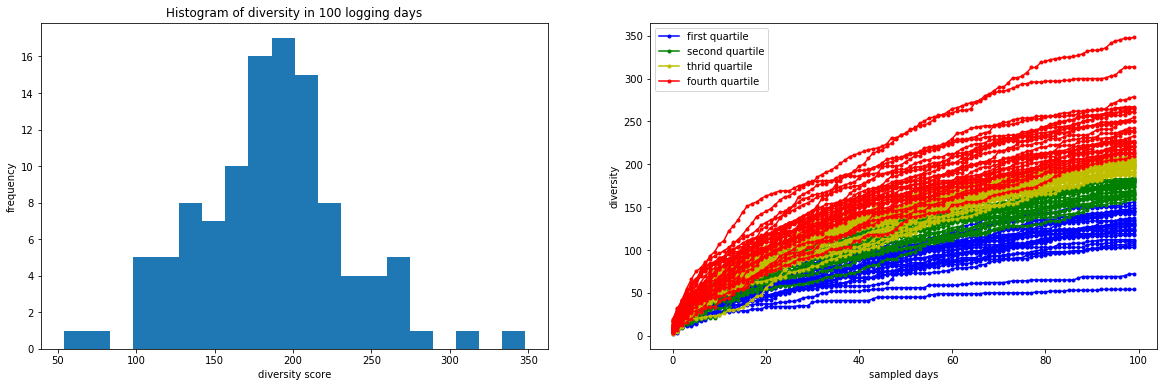

In [103]:
diversity_log2 = {}
for parID in df_log2.reset_index()['ParticipantID'].unique():
    df_temp = df_log2.query('ParticipantID == @parID' )
    unique_food_num = len(df_temp['Parsed food'].unique())
    diversity_log2[parID] = unique_food_num
diversity_value_log2 = diversity_log2.values()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.hist(diversity_value_log2, bins=20)
ax1.set_title("Histogram of diversity in 100 logging days")
ax1.set_xlabel("diversity score")
ax1.set_ylabel("frequency")

df_diversity_log2 = pd.Series(diversity_log2).to_frame()
df_diversity_log2.rename({0:'diversity'}, axis='columns',inplace=True)
df_diversity_log2.sort_values(by=['diversity'],inplace=True)
df_diversity_log2.reset_index(inplace=True)
df_diversity_log2.rename({'index':'ParticipantID'}, axis='columns',inplace=True)

col = 'diversity'
q = df_diversity_log2.quantile([0.00, 0.25, 0.50, 0.75, 1.00])
df_diversity_log2['quartile'] = np.where(
    ((df_diversity_log2[col]>=q[col][0.00]) & (df_diversity_log2[col]<q[col][0.25])), 0.25, np.where(
    ((df_diversity_log2[col]>=q[col][0.25]) & (df_diversity_log2[col]<q[col][0.50])), 0.50, 
        np.where(((df_diversity_log2[col]>=q[col][0.50]) & (df_diversity_log2[col]<q[col][0.75])),0.75,1.00))) 
# line plot
color = ['b','g','y','r']
for quartile,c,l in zip([0.25, 0.50, 0.75, 1.00],color,['first quartile','second quartile','thrid quartile','fourth quartile']):
    group = df_diversity_log2[df_diversity_log2['quartile']==quartile]['ParticipantID']    
    count = 0
    for par in group:
        diversity = extract_diversity(par,food_dict_log2)
        if count == 0:
            ax2.plot(diversity,marker='.',color=c,label=l)
        else:
            ax2.plot(diversity,marker='.',color=c)
        count+=1

ax2.set_xlabel('sampled days')
ax2.set_ylabel('diversity')
ax2.legend()

## logging day check

In [204]:
df_index

Time           Logged entry  \
ParticipantID Date                                           
9bbi18050005  2018-05-08  18.016667         gatorade 16 oz   
              2018-05-08  19.083333  2 grilled shrim tacos   
              2018-05-08  19.100000                 1 coke   
              2018-05-08  12.900000            granola bar   
              2018-05-08  11.650000            granola bar   
...                             ...                    ...   
9bbj18110064  2019-12-18  17.750000             meat pasta   
              2019-12-18  17.750000             meat pasta   
              2019-12-18  12.750000        turkey sandwich   
              2019-12-18   9.000000                oatmeal   
              2019-12-18  22.800000                cooffee   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
9bbj18110064  2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          b   

                              Parsed food  DayPassed         group  
ParticipantID Date                                                  
9bbi18050005  2018-05-08         gatorade          0      baseline  
              2018-05-08      shrimp taco          0      baseline  
              2018-05-08             coke          0      baseline  
              2018-05-08      granola bar          0      baseline  
              2018-05-08      granola bar          0      baseline  
...                                   ...        ...           ...  
9bbj18110064  2019-12-18             meat        377  intervention  
              2019-12-18            pasta        377  intervention  
              2019-12-18  turkey sandwich        377  intervention  
              2019-12-18          oatmeal        377  intervention  
              2019-12-18           coffee        377  intervention  

[184092 rows x 6 columns]

In [208]:
df_100 = df_index.query('DayPassed<=100')

In [214]:
df_100

Time              Logged entry  \
ParticipantID Date                                              
9bbi18050005  2018-05-08  18.016667            gatorade 16 oz   
              2018-05-08  19.083333     2 grilled shrim tacos   
              2018-05-08  19.100000                    1 coke   
              2018-05-08  12.900000               granola bar   
              2018-05-08  11.650000               granola bar   
...                             ...                       ...   
9bbj18110064  2019-03-13   8.666667  2 eggs on toast with avo   
              2019-03-13   8.666667  2 eggs on toast with avo   
              2019-03-15  18.000000               meat burger   
              2019-03-15  18.000000               meat burger   
              2019-03-16  18.166667           stuffed cabbage   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
9bbj18110064  2019-03-13                                          f   
              2019-03-13                                          f   
              2019-03-15                                          f   
              2019-03-15                                          f   
              2019-03-16                                          f   

                          Parsed food  DayPassed         group  
ParticipantID Date                                              
9bbi18050005  2018-05-08     gatorade          0      baseline  
              2018-05-08  shrimp taco          0      baseline  
              2018-05-08         coke          0      baseline  
              2018-05-08  granola bar          0      baseline  
              2018-05-08  granola bar          0      baseline  
...                               ...        ...           ...  
9bbj18110064  2019-03-13    egg toast         97  intervention  
              2019-03-13      avocado         97  intervention  
              2019-03-15         meat         99  intervention  
              2019-03-15       burger         99  intervention  
              2019-03-16      cabbage        100  intervention  

[88776 rows x 6 columns]

In [231]:
df_100.query('ParticipantID == "9bbi18050005"')['DayPassed'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  90,  91,  93,  95,  97,  98,
        99, 100])

,ParticipantID,gaps,quartile
0,9bbi18100060,0.000000,0.25
1,9bbi18100062,0.000000,0.25
2,9bbi19020074,0.000000,0.25
3,9bbi19020076,0.000000,0.25
4,9bbi19030094,0.000000,0.25
...,...,...,...
124,9bbi18070038,5.888889,1.00
125,9bbi19070134,6.000000,1.00
126,9bbi19090144,6.833333,1.00
127,9bbi19050128,8.333333,1.00


In [236]:
# gaps detection
def detect_gaps(df,par):
    days = df.query('ParticipantID == @par')['DayPassed'].unique()
    gaps = []

    flag = False
    for index in range(len(days)-1):
        if days[index] != days[index+1]-1 and flag ==  False:
            flag = True
        if flag == True and days[index] != days[index+1]-1:
            gaps.append(days[index+1]-days[index]-1)
        if flag == True and days[index] == days[index+1]-1:
            flag = False
    if len(gaps)==0:
        return [0]
    return gaps
        

In [230]:
detect_gaps('9bbi18050005')

[1, 1, 2, 1, 1, 1, 1]

In [241]:
gaps_dict = {}
for par in df_100.reset_index()['ParticipantID'].unique():
    gaps = detect_gaps(df_100,par)
    avg_gaps = np.mean(gaps)
    gaps_dict[par] = avg_gaps
sorted_gaps = sorted(gaps_dict.items(), key=lambda kv: kv[1],reverse=False)    
pars = [x[0] for x in sorted_gaps]
gaps = [x[1] for x in sorted_gaps]
data = {'ParticipantID':pars,'gaps':gaps}
df_gaps = pd.DataFrame(data)

In [299]:
def plot_quartile():
    #fig, ((ax1, ax2,ax3,ax4,ax5), (ax6, ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3, 5,sharey=True,figsize=(20,10))
    fig, ((ax1, ax2),(ax3,ax4))= plt.subplots(2 ,2, figsize=(10, 8))
    for (quartile,ax) in zip([0.25,0.50,0.75,1.00],[ax1, ax2,ax3,ax4]):
        for par in df_gaps.query('quartile == @quartile').reset_index()['ParticipantID'].unique():
            ax.plot(df_100.query('ParticipantID == @par')['DayPassed'].unique())
        ax.set_title(f'logging days vs days count for quartile {quartile}')
        ax.set_xlabel('logging days')
        ax.set_ylabel('days count')
    fig.tight_layout(pad=3.0)

    

In [304]:
q

,gaps
0.00,0.000000
0.25,1.000000
0.50,1.473684
0.75,2.555556
1.00,9.800000


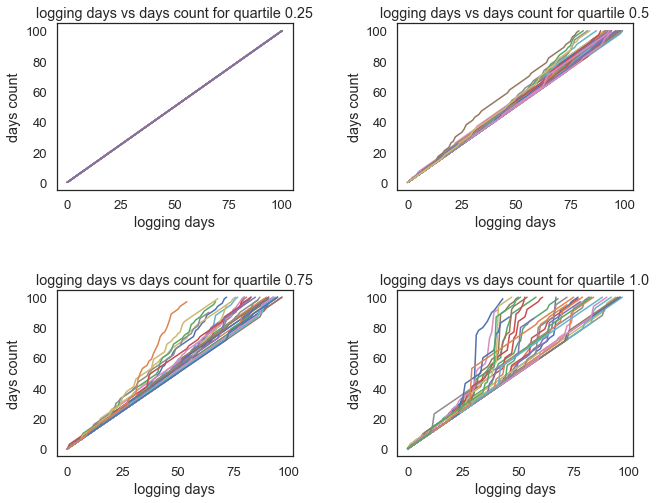

In [300]:
plot_quartile()

In [265]:
col = 'gaps'
q = df_gaps.quantile([0.00, 0.25, 0.50, 0.75, 1.00])
df_gaps['quartile'] = np.where(
    ((df_gaps[col]>=q[col][0.00]) & (df_gaps[col]<q[col][0.25])), 0.25, np.where(
    ((df_gaps[col]>=q[col][0.25]) & (df_gaps[col]<q[col][0.50])), 0.50, 
        np.where(((df_gaps[col]>=q[col][0.50]) & (df_gaps[col]<q[col][0.75])),0.75,1.00))) 

Text(0, 0.5, 'days count')

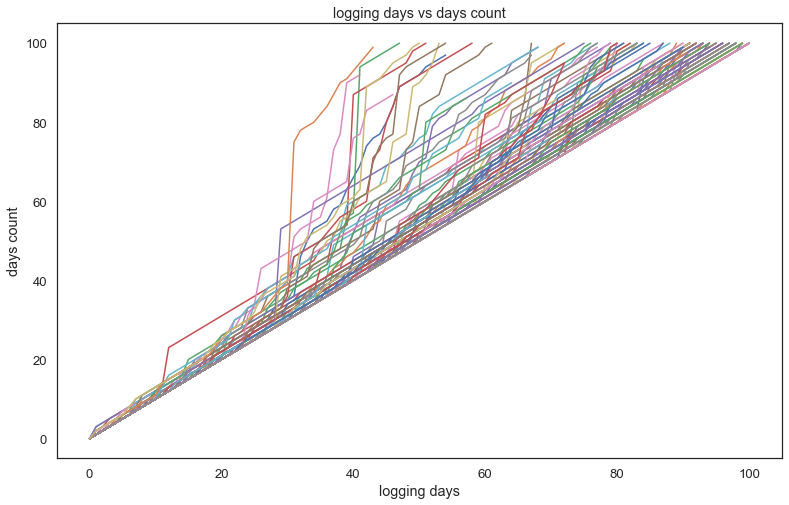

In [223]:
plt.figure(figsize=(13,8))
count = 0
for par in df_100.reset_index()['ParticipantID'].unique():
    count+=1
    plt.plot(df_100.query('ParticipantID == @par')['DayPassed'].unique())
plt.title('logging days vs days count')
plt.xlabel('logging days')
plt.ylabel('days count')

## Quartile: logging days

In [314]:
logs_dict = {}
for par in df_100.reset_index()['ParticipantID'].unique():
    logs = len(df_100.query('ParticipantID == @par')['DayPassed'].unique())
    
    logs_dict[par] = logs
sorted_logs = sorted(logs_dict.items(), key=lambda kv: kv[1],reverse=False)    
pars = [x[0] for x in sorted_logs]
logs = [x[1] for x in sorted_logs]
data = {'ParticipantID':pars,'logs':logs}
df_logs = pd.DataFrame(data)

In [316]:
df_logs

,ParticipantID,logs
0,9bbi18060017,42
1,9bbi19100165,44
2,9bbi19090144,47
3,9bbi18070038,48
4,9bbj18110064,51
...,...,...
124,9bbi19050119,101
125,9bbi19050121,101
126,9bbi19060130,101
127,9bbi19070138,101


In [317]:
col = 'logs'
q = df_logs.quantile([0.00, 0.25, 0.50, 0.75, 1.00])
df_logs['quartile'] = np.where(
    ((df_logs[col]>=q[col][0.00]) & (df_logs[col]<q[col][0.25])), 0.25, np.where(
    ((df_logs[col]>=q[col][0.25]) & (df_logs[col]<q[col][0.50])), 0.50, 
        np.where(((df_logs[col]>=q[col][0.50]) & (df_logs[col]<q[col][0.75])),0.75,1.00))) 

In [319]:
def plot_quartile2():
    #fig, ((ax1, ax2,ax3,ax4,ax5), (ax6, ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3, 5,sharey=True,figsize=(20,10))
    fig, ((ax1, ax2),(ax3,ax4))= plt.subplots(2 ,2, figsize=(10, 8))
    for (quartile,ax) in zip([0.25,0.50,0.75,1.00],[ax1, ax2,ax3,ax4]):
        for par in df_logs.query('quartile == @quartile').reset_index()['ParticipantID'].unique():
            ax.plot(df_100.query('ParticipantID == @par')['DayPassed'].unique())
        ax.set_title(f'logging days vs days count for quartile {quartile}')
        ax.set_xlabel('logging days')
        ax.set_ylabel('days count')
    fig.tight_layout(pad=3.0)

    

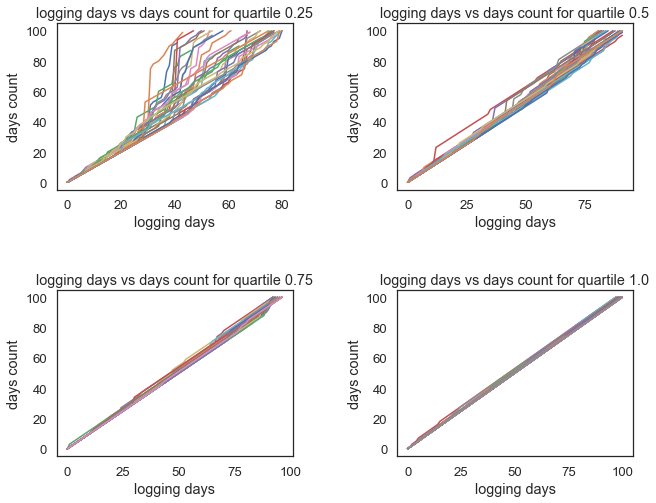

In [320]:
plot_quartile2()

In [104]:
def extract_diversity_log(parID,food_dict):
    diversity = []
    unique_food = []
    par_dict = food_dict[parID]
    for day,foods in par_dict.items():
        unique_food += foods
        diversity.append(len(np.unique(unique_food)))

    return diversity
        

In [105]:
a=extract_diversity_log('9bbj18110064',food_dict_log)

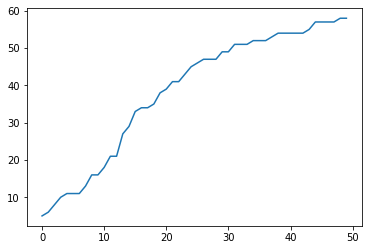

In [108]:
plt.plot(a)

In [109]:
np.exp(1)

2.718281828459045

['9bbi19030089']


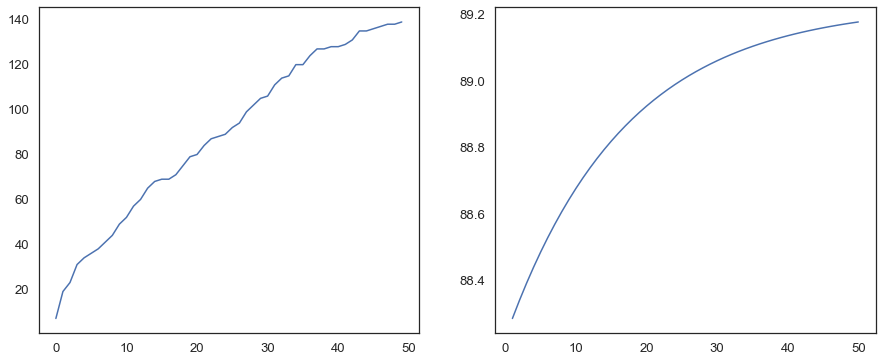

In [201]:


# Scientific libraries
import numpy as np
from scipy.optimize import curve_fit

pars = list(df_log.reset_index()['ParticipantID'].unique())
par = random.sample(pars,1)
print(par)
x = np.array(range(1,51))
y = extract_diversity_log(*par,food_dict_log)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(y)

def exponenial_func(x, a, b):
    return a-np.exp(b*x)


def days_to_value(pest, y):
    '''
    pest = [a, b]
    y = a * exp( b * x )
    ln(y) - ln(a) = b * x
    x = ( ln(y) - ln(a) ) / b
    '''
    return (np.log(y) - np.log(pest[0]))/pest[1]

pest, pcov = curve_fit(exponenial_func, range(len(y)), y,maxfev = 100000000)

xx = np.array(range(1,51))
yy = exponenial_func(xx, *pest)
ax2.plot(xx,yy)

In [111]:
xx

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

['9bbi19090149']


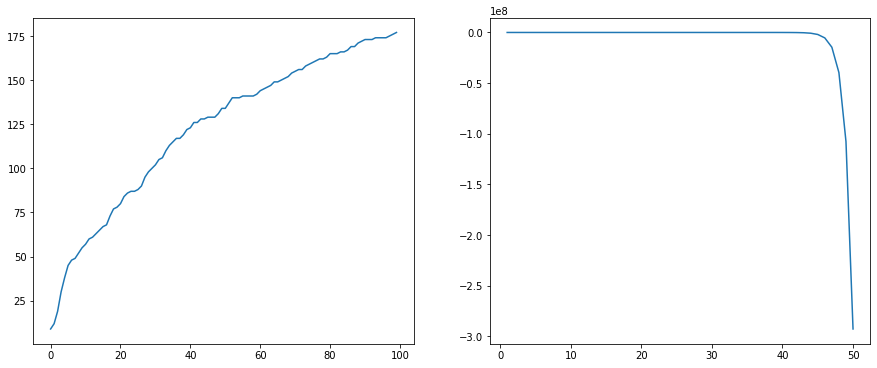

In [112]:
pars = list(df_log2.reset_index()['ParticipantID'].unique())
par = random.sample(pars,1)
print(par)
x = np.array(range(1,51))
y = extract_diversity_log(*par,food_dict_log2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(y)

def exponenial_func(x, a, b):
    return a*np.exp(b*x)


pest, pcov = curve_fit(exponenial_func, range(len(y)), y)

xx = np.array(range(1,51))
yy = exponenial_func(xx, *pest)
ax2.plot(xx,yy)

In [113]:
pest

array([-5.64412909e-14,  9.99999995e-01])

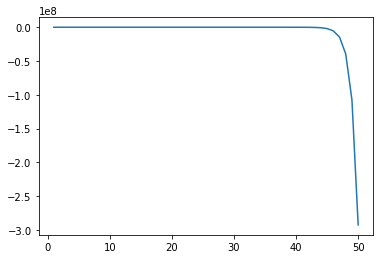

In [114]:
plt.plot(xx,yy)

In [115]:
exfunc(range(0,50),case_p_est[0],case_p_est[1])

array([-1.64387407e-14, -4.46851301e-14, -1.21466777e-13, -3.30180932e-13,
       -8.97524826e-13, -2.43972542e-12, -6.63186127e-12, -1.80272680e-11,
       -4.90031948e-11, -1.33204494e-10, -3.62087355e-10, -9.84255475e-10,
       -2.67548377e-09, -7.27271890e-09, -1.97692996e-08, -5.37385278e-08,
       -1.46076463e-07, -3.97076996e-07, -1.07936718e-06, -2.93402419e-06,
       -7.97550462e-06, -2.16796693e-05, -5.89314509e-05, -1.60192292e-04,
       -4.35447795e-04, -1.18366983e-03, -3.21754818e-03, -8.74620274e-03,
       -2.37746439e-02, -6.46261825e-02, -1.75672177e-01, -4.77526487e-01,
       -1.29805157e+00, -3.52846999e+00, -9.59137584e+00, -2.60720626e+01,
       -7.08712139e+01, -1.92647933e+02, -5.23671374e+02, -1.42348638e+03,
       -3.86943715e+03, -1.05182207e+04, -2.85914881e+04, -7.77197224e+04,
       -2.11264109e+05, -5.74275387e+05, -1.56104235e+06, -4.24335304e+06,
       -1.15346294e+07, -3.13543736e+07])

## Analyze relationship between diversity and overlap score

In [116]:
df_diversity

,ParticipantID,diversity
0,9bbi18070044,15
1,9bbj18110064,21
2,9bbi19060133,23
3,9bbi19100165,28
4,9bbi19100158,31
...,...,...
124,9bbi18090058,106
125,9bbi19030092,108
126,9bbi19050128,121
127,9bbi19030094,127


In [117]:
#join fix-10 overlap df with diversity sf
df_new=df_ran_fix.join(df_diversity.set_index('ParticipantID'),on="ParticipantID")

In [118]:
# add diversity score to the dataframe we are interested in
def add_diversity(df):
    df_new = df.join(df_diversity.set_index('ParticipantID'),on="ParticipantID")
    return df_new
    

Observe overlap score for each quartile of diversity

In [119]:
df_diversity

,ParticipantID,diversity
0,9bbi18070044,15
1,9bbj18110064,21
2,9bbi19060133,23
3,9bbi19100165,28
4,9bbi19100158,31
...,...,...
124,9bbi18090058,106
125,9bbi19030092,108
126,9bbi19050128,121
127,9bbi19030094,127


In [120]:
q = df_diversity.quantile([0.00, 0.25, 0.50, 0.75, 1.00])

In [121]:
q

,diversity
0.00,15.0
0.25,51.0
0.50,66.0
0.75,78.0
1.00,127.0


In [122]:
col = 'diversity'

In [123]:

df_new['quartile'] = np.where(
    ((df_new[col]>=q[col][0.00]) & (df_new[col]<q[col][0.25])), 0.25, np.where(
    ((df_new[col]>=q[col][0.25]) & (df_new[col]<q[col][0.50])), 0.50, 
        np.where(((df_new[col]>=q[col][0.50]) & (df_new[col]<q[col][0.75])),0.75,1.00))) 



In [124]:
df_new[:20]

,ParticipantID,day,overlap,diversity,quartile
0,9bbi18050005,1.0,0.2293,97,1.00
1,9bbi18050005,3.0,0.3156,97,1.00
2,9bbi18050005,7.0,0.5210,97,1.00
3,9bbi18050005,10.0,0.6205,97,1.00
4,9bbi18050009,1.0,0.3268,67,0.75
5,9bbi18050009,3.0,0.5383,67,0.75
6,9bbi18050009,7.0,0.7471,67,0.75
7,9bbi18050009,10.0,0.8336,67,0.75
8,9bbi18050011,1.0,0.2835,71,0.75
9,9bbi18050011,3.0,0.4579,71,0.75


In [125]:
df_new['diversity'].describe()

count    516.000000
mean      65.635659
std       21.063358
min       15.000000
25%       51.000000
50%       66.000000
75%       78.000000
max      127.000000
Name: diversity, dtype: float64

In [126]:
df_new.groupby(['quartile','day'])['overlap'].describe()

count      mean       std     min       25%      50%       75%  \
quartile day                                                                    
0.25     1.0    32.0  0.269253  0.094173  0.1467  0.213425  0.25515  0.308825   
         3.0    32.0  0.464838  0.090913  0.2893  0.418325  0.44810  0.498975   
         7.0    32.0  0.619194  0.095874  0.4329  0.567650  0.61490  0.687525   
         10.0   32.0  0.725288  0.093791  0.4771  0.676650  0.72280  0.788125   
0.50     1.0    32.0  0.288672  0.058011  0.1821  0.242450  0.28915  0.333600   
         3.0    32.0  0.435634  0.061392  0.3235  0.390400  0.43125  0.486700   
         7.0    32.0  0.635091  0.082835  0.4822  0.545900  0.66260  0.698075   
         10.0   32.0  0.733409  0.068350  0.5772  0.673675  0.74575  0.785850   
0.75     1.0    31.0  0.284706  0.060529  0.1722  0.242750  0.28440  0.325600   
         3.0    31.0  0.421658  0.075762  0.2876  0.369650  0.42280  0.473900   
         7.0    31.0  0.630632  0.084114  0.4690  0.577650  0.64090  0.686250   
         10.0   31.0  0.730506  0.076507  0.5969  0.678100  0.74370  0.780400   
1.00     1.0    34.0  0.303512  0.054625  0.1921  0.271175  0.29695  0.329650   
         3.0    34.0  0.443350  0.074637  0.3147  0.391175  0.44215  0.485475   
         7.0    34.0  0.653247  0.067316  0.5210  0.597475  0.66390  0.705225   
         10.0   34.0  0.750676  0.062863  0.6205  0.696300  0.75470  0.808650   

                  max  
quartile day           
0.25     1.0   0.6317  
         3.0   0.7690  
         7.0   0.8756  
         10.0  0.9201  
0.50     1.0   0.3949  
         3.0   0.5387  
         7.0   0.7593  
         10.0  0.8346  
0.75     1.0   0.3956  
         3.0   0.5637  
         7.0   0.7726  
         10.0  0.8540  
1.00     1.0   0.4629  
         3.0   0.6345  
         7.0   0.8111  
         10.0  0.8863

## Find correlation between diversity and overlapscore

In [127]:
df_new[df_new['day']==10]

,ParticipantID,day,overlap,diversity,quartile
3,9bbi18050005,10.0,0.6205,97,1.00
7,9bbi18050009,10.0,0.8336,67,0.75
11,9bbi18050011,10.0,0.7774,71,0.75
15,9bbi18060012,10.0,0.7074,49,0.25
19,9bbi18060013,10.0,0.7546,67,0.75
...,...,...,...,...,...
499,9bbi19110168,10.0,0.7215,67,0.75
503,9bbi19110169,10.0,0.7556,94,1.00
507,9bbi19110171,10.0,0.7889,67,0.75
511,9bbi19120173,10.0,0.7339,67,0.75


In [128]:
# find correlation w.r.t specific subsampling method
def find_correlation(df,n_day):
    data = df[df['day']==n_day]
    #fit linear model
    X = data['diversity'].values.reshape(-1,1)
    y = data['overlap'].values.reshape(-1,1)
    
    reg = LinearRegression()
    reg.fit(X, y)
    
    print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
    
    #plot lines
    
    predictions = reg.predict(X)
    plt.figure(figsize=(16, 8))
    plt.scatter(
        data['diversity'],
        data['overlap'],
        c='black'
    )
    plt.plot(
        data['diversity'],
        predictions,
        c='blue',
        linewidth=2
    )
    plt.xlabel("diet diversity")
    plt.ylabel("overlap scores")
    plt.show()
    
    X = data['diversity']
    y = data['overlap']
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

    
    sns.set(style='white', font_scale=1.2)

    g = sns.regplot(data=data, x='diversity', y='overlap', color="xkcd:muted blue")
    #g = g.plot_marginals(sns.distplot, kde=False, bins=12, color="xkcd:bluey grey")
    #g.ax_joint.text(145, 95, 'r = 0.45, p < .001', fontstyle='italic')

    # Calculate pearson coefficient and p-value
    pearson_coef, p_value = stats.pearsonr(data['diversity'], data['overlap'])
    print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

    

The linear model is: Y = 0.70997 + 0.00038511X


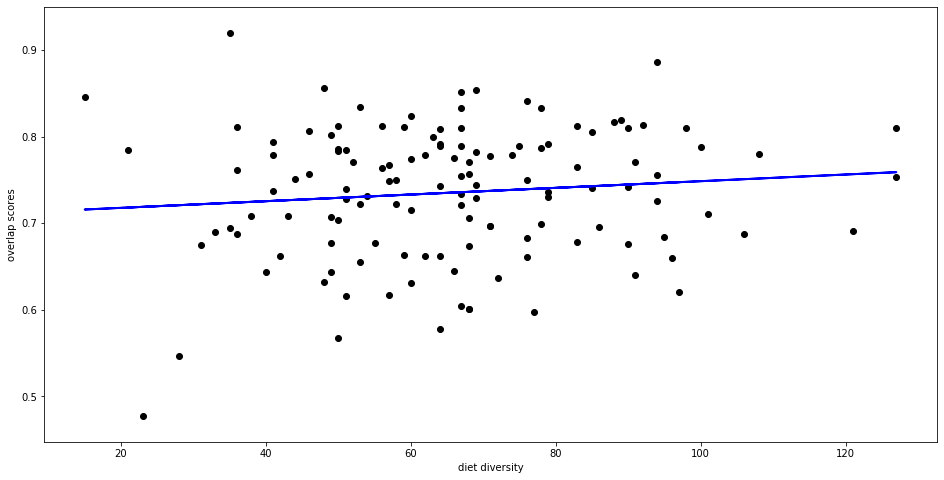

                            OLS Regression Results                            
Dep. Variable:                overlap   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.480
Date:                Sat, 23 Oct 2021   Prob (F-statistic):              0.226
Time:                        19:11:16   Log-Likelihood:                 150.97
No. Observations:                 129   AIC:                            -297.9
Df Residuals:                     127   BIC:                            -292.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7100      0.022     32.535      0.0

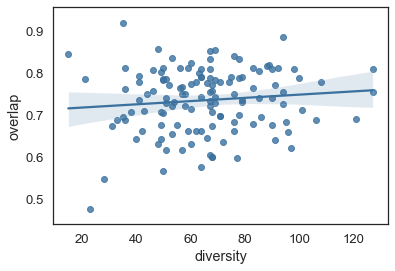

In [129]:
find_correlation(df_new,10)

Method to integrate top-k and n-days

In [130]:
def plot_linear(typed,k,n_days,food_dict):
    df= run_distribution_k(typed,k,food_dict)
    
    df_new=df.join(df_diversity.set_index('ParticipantID'),on="ParticipantID")
    find_correlation(df_new,n_days)
    return df_new

[0.28748915 0.44178527 0.63545116 0.7350031 ]
The linear model is: Y = 0.71018 + 0.00037813X


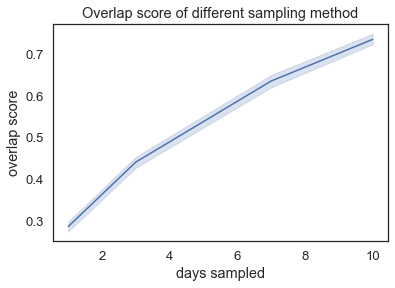

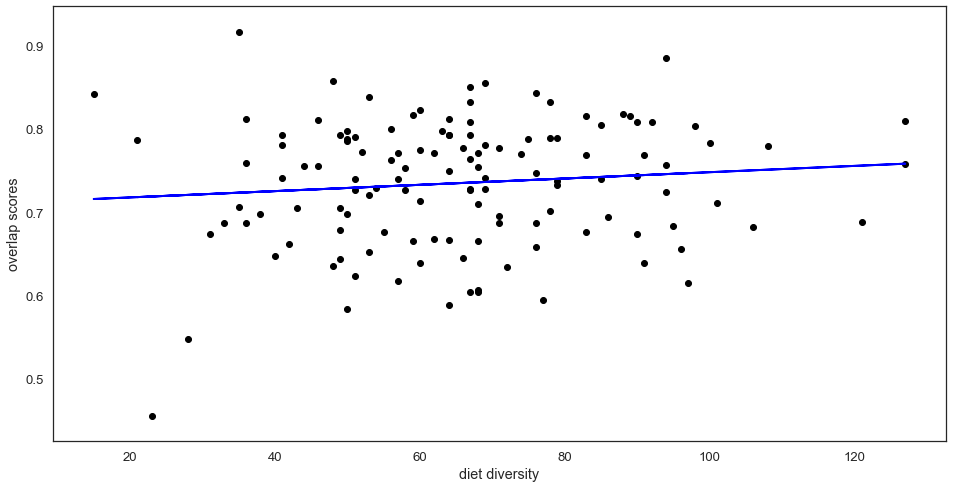

                            OLS Regression Results                            
Dep. Variable:                overlap   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.438
Date:                Sat, 23 Oct 2021   Prob (F-statistic):              0.233
Time:                        19:11:31   Log-Likelihood:                 151.47
No. Observations:                 129   AIC:                            -298.9
Df Residuals:                     127   BIC:                            -293.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7102      0.022     32.673      0.0

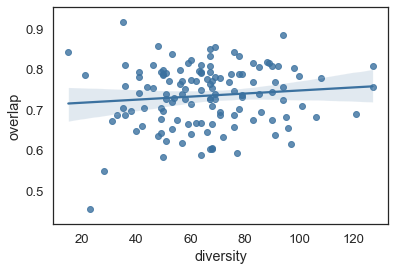

In [131]:
df=plot_linear('random',10,10,food_dict_base)

In [132]:
df

,ParticipantID,day,overlap,diversity
0,9bbi18050005,1.0,0.2250,97
1,9bbi18050005,3.0,0.3121,97
2,9bbi18050005,7.0,0.5226,97
3,9bbi18050005,10.0,0.6148,97
4,9bbi18050009,1.0,0.3225,67
...,...,...,...,...
511,9bbi19120173,10.0,0.7275,67
512,9bbj18110064,1.0,0.2638,21
513,9bbj18110064,3.0,0.5715,21
514,9bbj18110064,7.0,0.7057,21


## Diversity vs Meal

In [133]:
df_index

Time           Logged entry  \
ParticipantID Date                                           
9bbi18050005  2018-05-08  18.016667         gatorade 16 oz   
              2018-05-08  19.083333  2 grilled shrim tacos   
              2018-05-08  19.100000                 1 coke   
              2018-05-08  12.900000            granola bar   
              2018-05-08  11.650000            granola bar   
...                             ...                    ...   
9bbj18110064  2019-12-18  17.750000             meat pasta   
              2019-12-18  17.750000             meat pasta   
              2019-12-18  12.750000        turkey sandwich   
              2019-12-18   9.000000                oatmeal   
              2019-12-18  22.800000                cooffee   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
9bbj18110064  2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          b   

                              Parsed food  DayPassed         group  
ParticipantID Date                                                  
9bbi18050005  2018-05-08         gatorade          0      baseline  
              2018-05-08      shrimp taco          0      baseline  
              2018-05-08             coke          0      baseline  
              2018-05-08      granola bar          0      baseline  
              2018-05-08      granola bar          0      baseline  
...                                   ...        ...           ...  
9bbj18110064  2019-12-18             meat        377  intervention  
              2019-12-18            pasta        377  intervention  
              2019-12-18  turkey sandwich        377  intervention  
              2019-12-18          oatmeal        377  intervention  
              2019-12-18           coffee        377  intervention  

[184092 rows x 6 columns]

In [134]:
df_baseline = df_index[df_index['group']=='baseline']
df_baseline

Time             Logged entry  \
ParticipantID Date                                             
9bbi18050005  2018-05-08  18.016667           gatorade 16 oz   
              2018-05-08  19.083333    2 grilled shrim tacos   
              2018-05-08  19.100000                   1 coke   
              2018-05-08  12.900000              granola bar   
              2018-05-08  11.650000              granola bar   
...                             ...                      ...   
9bbj18110064  2018-12-20  18.250000            tofu stir fry   
              2018-12-20  12.250000  chicken burrito and avo   
              2018-12-20  12.250000  chicken burrito and avo   
              2018-12-20   8.500000        pancakes and eggs   
              2018-12-20   8.500000        pancakes and eggs   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
9bbj18110064  2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   

                              Parsed food  DayPassed     group  
ParticipantID Date                                              
9bbi18050005  2018-05-08         gatorade          0  baseline  
              2018-05-08      shrimp taco          0  baseline  
              2018-05-08             coke          0  baseline  
              2018-05-08      granola bar          0  baseline  
              2018-05-08      granola bar          0  baseline  
...                                   ...        ...       ...  
9bbj18110064  2018-12-20             tofu         14  baseline  
              2018-12-20  chicken burrito         14  baseline  
              2018-12-20          avocado         14  baseline  
              2018-12-20          pancake         14  baseline  
              2018-12-20              egg         14  baseline  

[17211 rows x 6 columns]

Separating food intake into meals

In [135]:
df_baseline['meal'] = np.where(((df_baseline['Time']>=4) & (df_baseline['Time']<=10)),'breakfast',
                               np.where(((df_baseline['Time']>10) & (df_baseline['Time']<=16)), 'lunch',
                                       np.where(((df_baseline['Time']>16) & (df_baseline['Time']<=22)),'dinner','snacks')))

/Users/suijialu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [136]:
df_baseline

Time             Logged entry  \
ParticipantID Date                                             
9bbi18050005  2018-05-08  18.016667           gatorade 16 oz   
              2018-05-08  19.083333    2 grilled shrim tacos   
              2018-05-08  19.100000                   1 coke   
              2018-05-08  12.900000              granola bar   
              2018-05-08  11.650000              granola bar   
...                             ...                      ...   
9bbj18110064  2018-12-20  18.250000            tofu stir fry   
              2018-12-20  12.250000  chicken burrito and avo   
              2018-12-20  12.250000  chicken burrito and avo   
              2018-12-20   8.500000        pancakes and eggs   
              2018-12-20   8.500000        pancakes and eggs   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
9bbj18110064  2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   

                              Parsed food  DayPassed     group       meal  
ParticipantID Date                                                         
9bbi18050005  2018-05-08         gatorade          0  baseline     dinner  
              2018-05-08      shrimp taco          0  baseline     dinner  
              2018-05-08             coke          0  baseline     dinner  
              2018-05-08      granola bar          0  baseline      lunch  
              2018-05-08      granola bar          0  baseline      lunch  
...                                   ...        ...       ...        ...  
9bbj18110064  2018-12-20             tofu         14  baseline     dinner  
              2018-12-20  chicken burrito         14  baseline      lunch  
              2018-12-20          avocado         14  baseline      lunch  
              2018-12-20          pancake         14  baseline  breakfast  
              2018-12-20              egg         14  baseline  breakfast  

[17211 rows x 7 columns]

Create diversity vs meal plot for selected participant

In [137]:
#version1: do NOT separate food and beverage
def diversity_meal_plot1(parID):
    df_par = df_baseline.query('ParticipantID == @parID')
    breakfast = df_par[df_par['meal']=='breakfast']['Parsed food'].unique()
    lunch = df_par[df_par['meal']=='lunch']['Parsed food'].unique()
    dinner = df_par[df_par['meal']=='dinner']['Parsed food'].unique()
    snacks = df_par[df_par['meal']=='snacks']['Parsed food'].unique()
    meals = ['breakfast','lunch','dinner','snacks']
    counts = [len(breakfast),len(lunch),len(dinner),len(snacks)]
    fig = plt.figure(figsize = (10, 5))
 
    # creating the bar plot
    plt.bar(meals, counts,
            width = 0.4)

    plt.xlabel("Meal")
    plt.ylabel("diversity")
    plt.title("Diversity vs Meal Plot")
    plt.show()
    
    

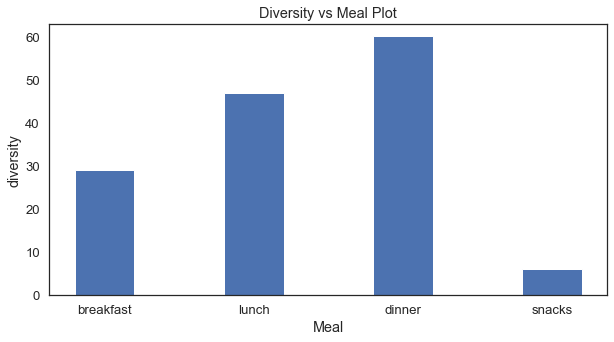

In [138]:
diversity_meal_plot1('9bbi19110169')

In [139]:
df_par = df_baseline.query('ParticipantID == "9bbi18050005"')
df_par[df_par['Beverage(b)/Food(f)/Water(w)/medication(m)']=='f']

Time                    Logged entry  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08  19.083333           2 grilled shrim tacos   
              2018-05-08  12.900000                     granola bar   
              2018-05-08  11.650000                     granola bar   
              2018-05-08  13.283333           sausage 2 egg burrito   
              2018-05-08  13.283333           sausage 2 egg burrito   
...                             ...                             ...   
              2018-05-22  17.383333      4 oz seared ahi brown rice   
              2018-05-22  17.383333   caesar salad small bowl fruit   
              2018-05-22  17.383333   caesar salad small bowl fruit   
              2018-05-22  12.983333            steak salad brn rice   
              2018-05-22  12.983333            steak salad brn rice   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          f   
              2018-05-08                                          f   
              2018-05-08                                          f   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
              2018-05-22                                          f   
              2018-05-22                                          f   
              2018-05-22                                          f   
              2018-05-22                                          f   
              2018-05-22                                          f   

                           Parsed food  DayPassed     group    meal  
ParticipantID Date                                                   
9bbi18050005  2018-05-08   shrimp taco          0  baseline  dinner  
              2018-05-08   granola bar          0  baseline   lunch  
              2018-05-08   granola bar          0  baseline   lunch  
              2018-05-08   egg burrito          0  baseline   lunch  
              2018-05-08       sausage          0  baseline   lunch  
...                                ...        ...       ...     ...  
              2018-05-22    brown rice         14  baseline  dinner  
              2018-05-22  caesar salad         14  baseline  dinner  
              2018-05-22         fruit         14  baseline  dinner  
              2018-05-22   steak salad         14  baseline   lunch  
              2018-05-22          rice         14  baseline   lunch  

[111 rows x 7 columns]

In [140]:
#version2: DO separate food and beverage
def diversity_meal_plot2(parID):
    df_par = df_baseline.query('ParticipantID == @parID')
    df_f = df_par[df_par['Beverage(b)/Food(f)/Water(w)/medication(m)']=='f']
    df_b = df_par[df_par['Beverage(b)/Food(f)/Water(w)/medication(m)']=='b']
    breakfast_f = df_f[df_f['meal']=='breakfast']['Parsed food'].unique()
    breakfast_b = df_b[df_b['meal']=='breakfast']['Parsed food'].unique()
    lunch_f = df_f[df_f['meal']=='lunch']['Parsed food'].unique()
    lunch_b = df_b[df_b['meal']=='lunch']['Parsed food'].unique()
    dinner_f = df_f[df_f['meal']=='dinner']['Parsed food'].unique()
    dinner_b = df_b[df_b['meal']=='dinner']['Parsed food'].unique()
    snacks_f = df_f[df_f['meal']=='snacks']['Parsed food'].unique()
    snacks_b = df_b[df_b['meal']=='snacks']['Parsed food'].unique()
    meals = ['breakfast','lunch','dinner','snacks']
    counts_f = [len(breakfast_f),len(lunch_f),len(dinner_f),len(snacks_f)]
    counts_b = [len(breakfast_b),len(lunch_b),len(dinner_b),len(snacks_b)]
    
    #multiple bar plot
    fig = plt.figure(figsize = (10, 5))
 
    X_axis = np.arange(len(meals))
  
    plt.bar(X_axis - 0.2, counts_f, 0.4, label = 'food diversity')
    plt.bar(X_axis + 0.2, counts_b, 0.4, label = 'beverage diversity')

    plt.xticks(X_axis, meals)
    plt.xlabel("Meal")
    plt.ylabel("diversity")
    plt.title("Diversity vs Meal Plot")

    plt.legend()
    plt.show()
    
    #stacked bar plot
    ind = np.arange(len(meals))  
    width = 0.35 
    fig = plt.subplots(figsize =(10, 5))
    p1 = plt.bar(ind, counts_f, width,label='food')
    p2 = plt.bar(ind, counts_b, width,label='beverage',bottom=counts_f)
    plt.xticks(X_axis, meals)
    plt.xlabel("Meal")
    plt.ylabel("diversity")
    plt.title("Diversity vs Meal Plot")
    
    plt.legend((p1[0], p2[0]), ('food', 'beverage'))

    plt.show()
    
    


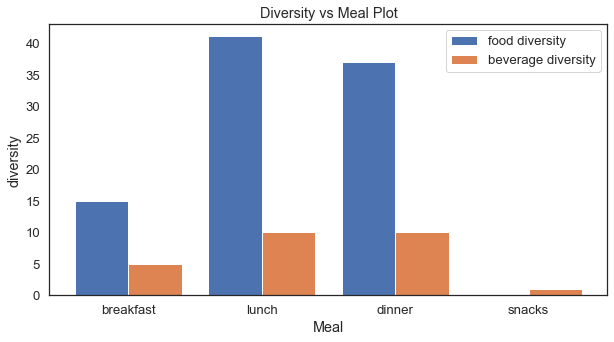

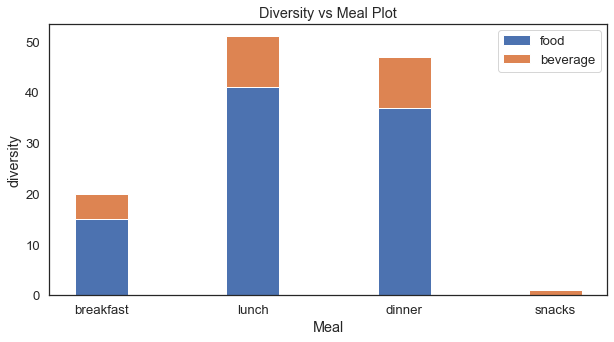

In [141]:
diversity_meal_plot2('9bbi18050005')

## Diet and Diversity study for week6 and 7 in intervention period

In [142]:
df_index

Time           Logged entry  \
ParticipantID Date                                           
9bbi18050005  2018-05-08  18.016667         gatorade 16 oz   
              2018-05-08  19.083333  2 grilled shrim tacos   
              2018-05-08  19.100000                 1 coke   
              2018-05-08  12.900000            granola bar   
              2018-05-08  11.650000            granola bar   
...                             ...                    ...   
9bbj18110064  2019-12-18  17.750000             meat pasta   
              2019-12-18  17.750000             meat pasta   
              2019-12-18  12.750000        turkey sandwich   
              2019-12-18   9.000000                oatmeal   
              2019-12-18  22.800000                cooffee   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
9bbj18110064  2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          f   
              2019-12-18                                          b   

                              Parsed food  DayPassed         group  
ParticipantID Date                                                  
9bbi18050005  2018-05-08         gatorade          0      baseline  
              2018-05-08      shrimp taco          0      baseline  
              2018-05-08             coke          0      baseline  
              2018-05-08      granola bar          0      baseline  
              2018-05-08      granola bar          0      baseline  
...                                   ...        ...           ...  
9bbj18110064  2019-12-18             meat        377  intervention  
              2019-12-18            pasta        377  intervention  
              2019-12-18  turkey sandwich        377  intervention  
              2019-12-18          oatmeal        377  intervention  
              2019-12-18           coffee        377  intervention  

[184092 rows x 6 columns]

In [143]:
df_inter67 = df_index[(df_index['DayPassed']>=38) & (df_index['DayPassed']<=52)]

In [144]:
df_inter67

Time                  Logged entry  \
ParticipantID Date                                                  
9bbi18050005  2018-06-15   8.000000  2 eggs 3 sausage links bagel   
              2018-06-15   8.000000  2 eggs 3 sausage links bagel   
              2018-06-15   8.000000  2 eggs 3 sausage links bagel   
              2018-06-16   9.883333       cup of coffee w creamer   
              2018-06-16   9.883333        egg scramble w veggies   
...                             ...                           ...   
9bbj18110064  2019-01-27  18.000000       salmon rice green beans   
              2019-01-27  12.500000       chicken burrito and avo   
              2019-01-27  12.500000       chicken burrito and avo   
              2019-01-27   9.000000             pancakes and eggs   
              2019-01-27   9.000000             pancakes and eggs   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-06-15                                          f   
              2018-06-15                                          f   
              2018-06-15                                          f   
              2018-06-16                                          b   
              2018-06-16                                          f   
...                                                             ...   
9bbj18110064  2019-01-27                                          f   
              2019-01-27                                          f   
              2019-01-27                                          f   
              2019-01-27                                          f   
              2019-01-27                                          f   

                              Parsed food  DayPassed         group  
ParticipantID Date                                                  
9bbi18050005  2018-06-15              egg         38  intervention  
              2018-06-15          sausage         38  intervention  
              2018-06-15            bagel         38  intervention  
              2018-06-16   coffee creamer         39  intervention  
              2018-06-16     egg scramble         39  intervention  
...                                   ...        ...           ...  
9bbj18110064  2019-01-27             rice         52  intervention  
              2019-01-27  chicken burrito         52  intervention  
              2019-01-27          avocado         52  intervention  
              2019-01-27          pancake         52  intervention  
              2019-01-27              egg         52  intervention  

[11997 rows x 6 columns]

## Overlap Score

[0.093875   0.18478125 0.26479687 0.3453125  0.42334375 0.49457812
 0.5645625  0.63435937 0.6975625  0.76276563]


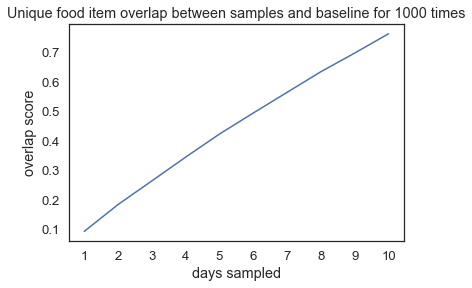

In [145]:
# calculate overlap score for each individual where we consider all food items
plot_overlap_distribution2('9bbi18050005',df_inter67,food_dict_67)

In [146]:
#make food log for week6,7 in intervention period

food_dict_67= {}
for par in par_67:
    food_dict_67[par] = {}
    
    df_temp = df_index.query('ParticipantID == @par and DayPassed >= 38 and DayPassed <= 52')
    df_temp.reset_index(inplace=True)
    dates = df_temp['Date'].unique()
    for date in dates:
        df_temp2 = df_temp.query('Date == @date')
    
        for index, value in df_temp2['Parsed food'].iteritems():
            if date not in food_dict_67[par].keys():
                food_dict_67[par][date] = [value]
            else:
                 food_dict_67[par][date].append(value)

In [147]:
# check how many days of record each participant has in week6,7
# only take for 12 days; excluding <= 1/4
days_for_par = {}
for parID in list(food_dict_67.keys()):
    days_for_par[parID] = len(food_dict_67[parID])
days_for_par = sorted(days_for_par.items(), key=lambda kv: kv[1],reverse=True)
days_for_par
count_12 = 0
par_to_delete = []
for (par,days) in days_for_par:
    if days >= 12:
        count_12+=1
    else:
        par_to_delete.append(par)
print(count_12/len(days_for_par))

        
        

0.796875


In [148]:

#update food_dict
for par in par_to_delete:
    food_dict_67.pop(par)
    
# update df_inter67
df_inter67.reset_index(inplace=True)
df_inter67.set_index(['ParticipantID'],inplace=True)
for par in par_to_delete:
    df_inter67.drop(par,inplace=True)

/Users/suijialu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [149]:
df_inter67.reset_index(inplace=True)
df_inter67.set_index(['ParticipantID', 'Date'],inplace=True)

[0.26770784 0.43798627 0.61361275 0.72832157]


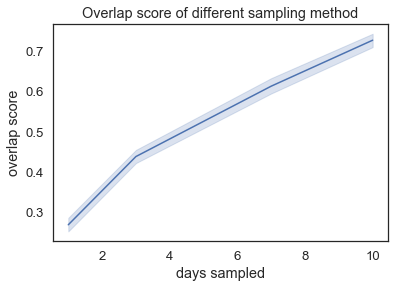

In [150]:
df_ran_fix = run_distribution_k('random',10,food_dict_67)

[0.2076732  0.41182843 0.62469216 0.73308543]


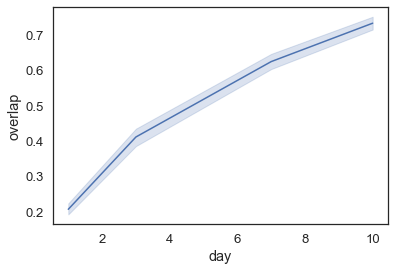

In [151]:
df_ran_nonfix = run_distribution('random',food_dict_67)

## Diversity Analysis

Text(0, 0.5, 'frequency')

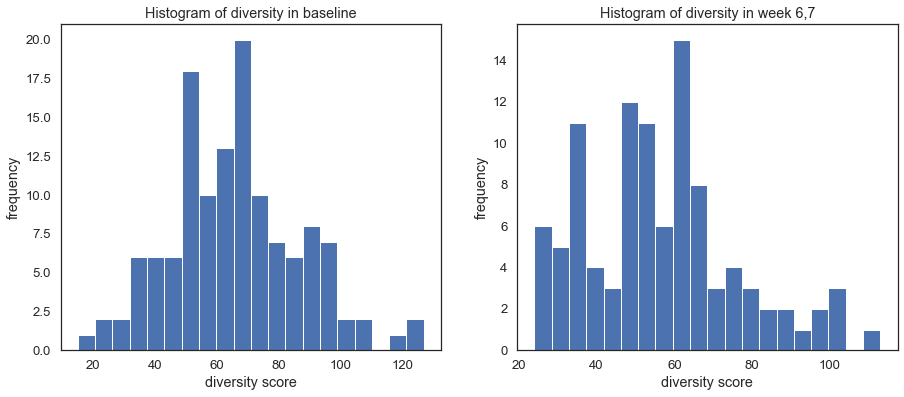

In [152]:
# calculate diversity of each participant in first 14 days 
# diversity: unique food items participants ate
diversity_base = {}
for parID in food_dict_base.keys():
    df_temp = df_index.query('ParticipantID == @parID and DayPassed <= 14' )
    unique_food_num = len(df_temp['Parsed food'].unique())
    diversity_base[parID] = unique_food_num
diversity_value_base = diversity_base.values()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(diversity_value_base, bins=20)
ax1.set_title("Histogram of diversity in baseline")
ax1.set_xlabel("diversity score")
ax1.set_ylabel("frequency")

diversity_67 = {}
for parID in food_dict_67.keys():
    df_temp = df_inter67.query('ParticipantID == @parID' )
    unique_food_num = len(df_temp['Parsed food'].unique())
    diversity_67[parID] = unique_food_num
diversity_value_67 = diversity_67.values()

ax2.hist(diversity_value_67, bins=20)
ax2.set_title("Histogram of diversity in week 6,7")
ax2.set_xlabel("diversity score")
ax2.set_ylabel("frequency")

In [153]:
df_baseline

Time             Logged entry  \
ParticipantID Date                                             
9bbi18050005  2018-05-08  18.016667           gatorade 16 oz   
              2018-05-08  19.083333    2 grilled shrim tacos   
              2018-05-08  19.100000                   1 coke   
              2018-05-08  12.900000              granola bar   
              2018-05-08  11.650000              granola bar   
...                             ...                      ...   
9bbj18110064  2018-12-20  18.250000            tofu stir fry   
              2018-12-20  12.250000  chicken burrito and avo   
              2018-12-20  12.250000  chicken burrito and avo   
              2018-12-20   8.500000        pancakes and eggs   
              2018-12-20   8.500000        pancakes and eggs   

                         Beverage(b)/Food(f)/Water(w)/medication(m)  \
ParticipantID Date                                                    
9bbi18050005  2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          b   
              2018-05-08                                          f   
              2018-05-08                                          f   
...                                                             ...   
9bbj18110064  2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   
              2018-12-20                                          f   

                              Parsed food  DayPassed     group       meal  
ParticipantID Date                                                         
9bbi18050005  2018-05-08         gatorade          0  baseline     dinner  
              2018-05-08      shrimp taco          0  baseline     dinner  
              2018-05-08             coke          0  baseline     dinner  
              2018-05-08      granola bar          0  baseline      lunch  
              2018-05-08      granola bar          0  baseline      lunch  
...                                   ...        ...       ...        ...  
9bbj18110064  2018-12-20             tofu         14  baseline     dinner  
              2018-12-20  chicken burrito         14  baseline      lunch  
              2018-12-20          avocado         14  baseline      lunch  
              2018-12-20          pancake         14  baseline  breakfast  
              2018-12-20              egg         14  baseline  breakfast  

[17211 rows x 7 columns]

In [154]:
df_baseline.query('ParticipantID == "9bbi18050005"')['Parsed food'].unique()

array(['gatorade', 'shrimp taco', 'coke', 'granola bar', 'yogurt',
       'egg burrito', 'sausage', 'grapefruit', 'pizza',
       'coffee cream sugar', 'fruit', 'lemon', 'chile', 'ice cream',
       'steak egg', 'cheese', 'potato', 'burrito', 'coffee creamer',
       'banana', 'iced coffee cream', 'taco salad', 'watermelon', 'bagel',
       'shrimp burrito', 'salsa', 'beer', 'carne asada', 'nacho',
       'spinach', 'avocado', 'bacon', 'mango', 'orange', 'melon',
       'peanut butter', 'walnut', 'salad', 'wine', 'chocolate cake',
       'caprese', 'salami', 'cracker', 'pear', 'margarita', 'beef', 'rib',
       'coleslaw', 'bbq', 'bean', 'hash brown', 'chorizo', 'taco',
       'pita chip', 'cinnamon', 'fried chicken', 'broccoli',
       'iced coffee', 'carne asada burrito', 'tuna sandwich', 'sourdough',
       'celery', 'chip', 'pork rib', 'corn', 'asparagus', 'egg',
       'orange juice', 'donut', 'breakfast burrito', 'milk', 'gummies',
       'brisket', 'sandwich', 'chicken caesar sa

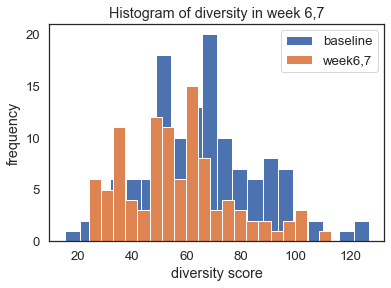

In [155]:
# calculate diversity of each participant in first 14 days 
# diversity: unique food items participants ate
diversity_base = {}
for parID in food_dict_base.keys():
    df_temp = df_index.query('ParticipantID == @parID and DayPassed <= 14' )
    unique_food_num = len(df_temp['Parsed food'].unique())
    diversity_base[parID] = unique_food_num
diversity_value_base = diversity_base.values()

plt.hist(diversity_value_base, bins=20,label='baseline')
plt.title("Histogram of diversity in baseline")
plt.xlabel("diversity score")
plt.ylabel("frequency")

diversity_67 = {}
for parID in food_dict_67.keys():
    df_temp = df_inter67.query('ParticipantID == @parID' )
    unique_food_num = len(df_temp['Parsed food'].unique())
    diversity_67[parID] = unique_food_num
diversity_value_67 = diversity_67.values()

plt.hist(diversity_value_67, bins=20,label='week6,7')
plt.title("Histogram of diversity in week 6,7")
plt.xlabel("diversity score")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [156]:
df_diversity_67 = pd.Series(diversity_67).to_frame()
df_diversity_67.rename({0:'diversity67'}, axis='columns',inplace=True)
df_diversity_67.sort_values(by=['diversity67'],inplace=True)
df_diversity_67.reset_index(inplace=True)
df_diversity_67.rename({'index':'ParticipantID'}, axis='columns',inplace=True)

In [157]:
df_diversity_67

,ParticipantID,diversity67
0,9bbi18080048,24
1,9bbi18070044,25
2,9bbi19050121,26
3,9bbi19090145,28
4,9bbi19020078,28
...,...,...
97,9bbi18080047,99
98,9bbi19060130,100
99,9bbi19040109,102
100,9bbi19100162,102


## Compare diversity from high, middle, and low group

In [158]:
# extract 5 participants of low, middle and high diversity
low_diversity = df_diversity_67[:5]
middle_diversity = df_diversity_67[49:54]
high_diversity = df_diversity_67[97:]
low_id = np.array(low_diversity['ParticipantID'])
mid_id = np.array(middle_diversity['ParticipantID'])
high_id = np.array(high_diversity['ParticipantID'])

In [159]:
low_diversity

,ParticipantID,diversity67
0,9bbi18080048,24
1,9bbi18070044,25
2,9bbi19050121,26
3,9bbi19090145,28
4,9bbi19020078,28


In [160]:
high_diversity

,ParticipantID,diversity67
97,9bbi18080047,99
98,9bbi19060130,100
99,9bbi19040109,102
100,9bbi19100162,102
101,9bbi19030094,113


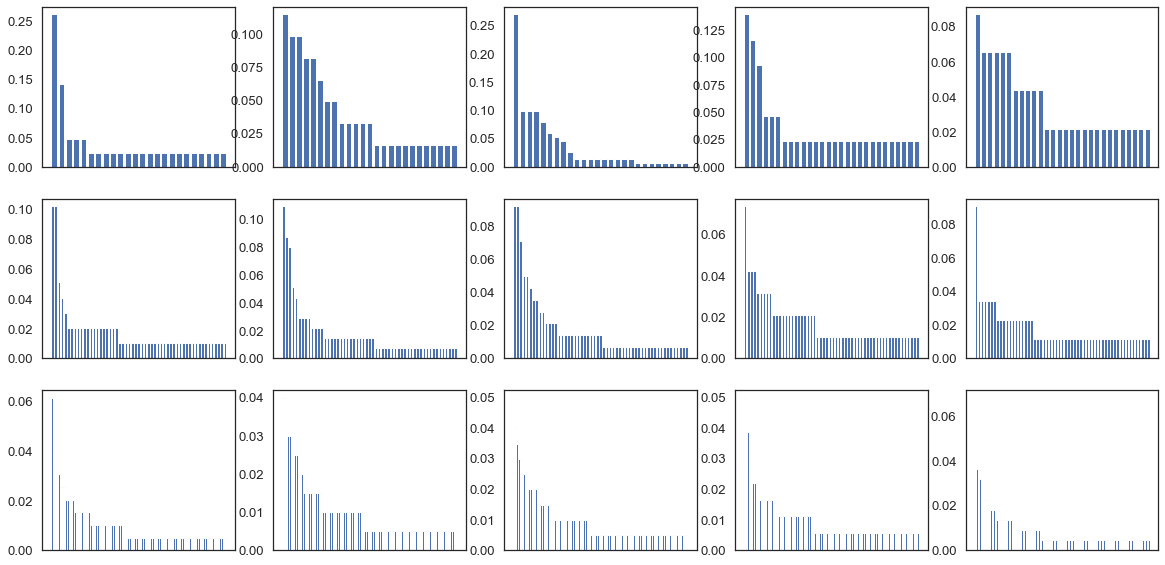

In [161]:

plt.figure(figsize=(20,10))
num_plot = 1
#low diversity
for parID in low_id:
    div,total_num = generate_div(parID,'all',df_inter67)
    plt.subplot(3,5,num_plot)
    plt.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks([])
    #axes[num_plot].set_xlabel("")
    num_plot +=1
#middle diversity
for parID in mid_id:
    div,total_num = generate_div(parID,'all',df_inter67)
    plt.subplot(3,5,num_plot)
    plt.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks([])
    num_plot +=1
#high diversity
for parID in high_id:
    div,total_num = generate_div(parID,'all',df_inter67)
    plt.subplot(3,5,num_plot)
    plt.bar(div.keys(), [x/total_num for x in div.values()])
    plt.xticks([])
    num_plot +=1




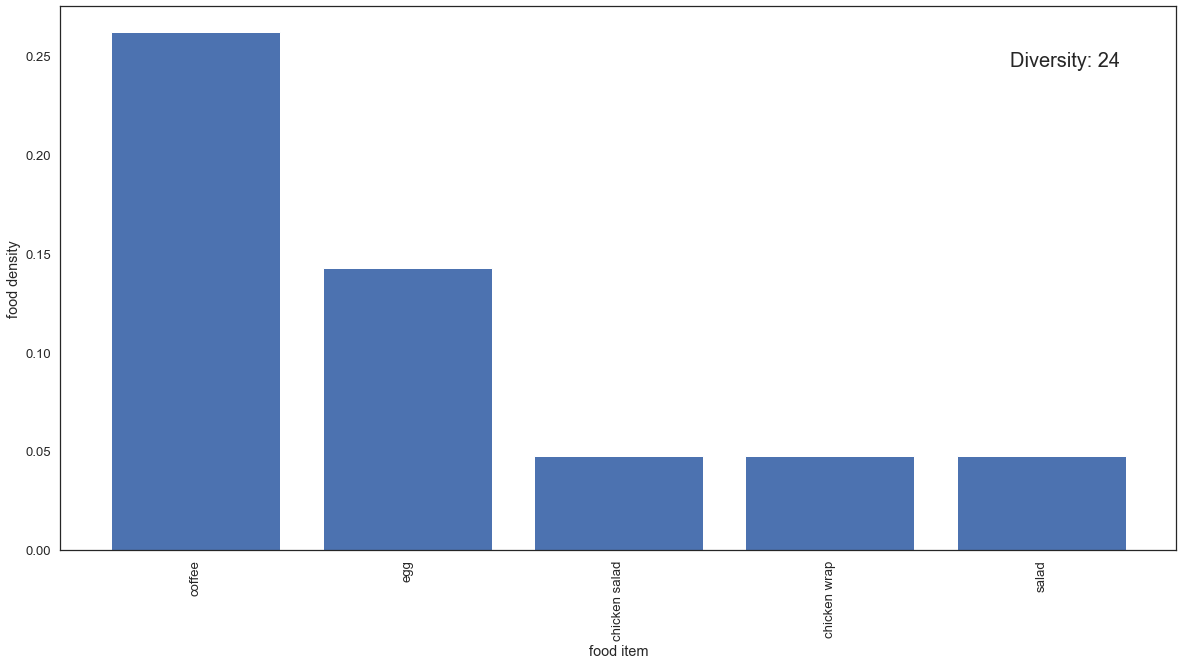

In [162]:
visualize_diversity('9bbi18080048',df_inter67)

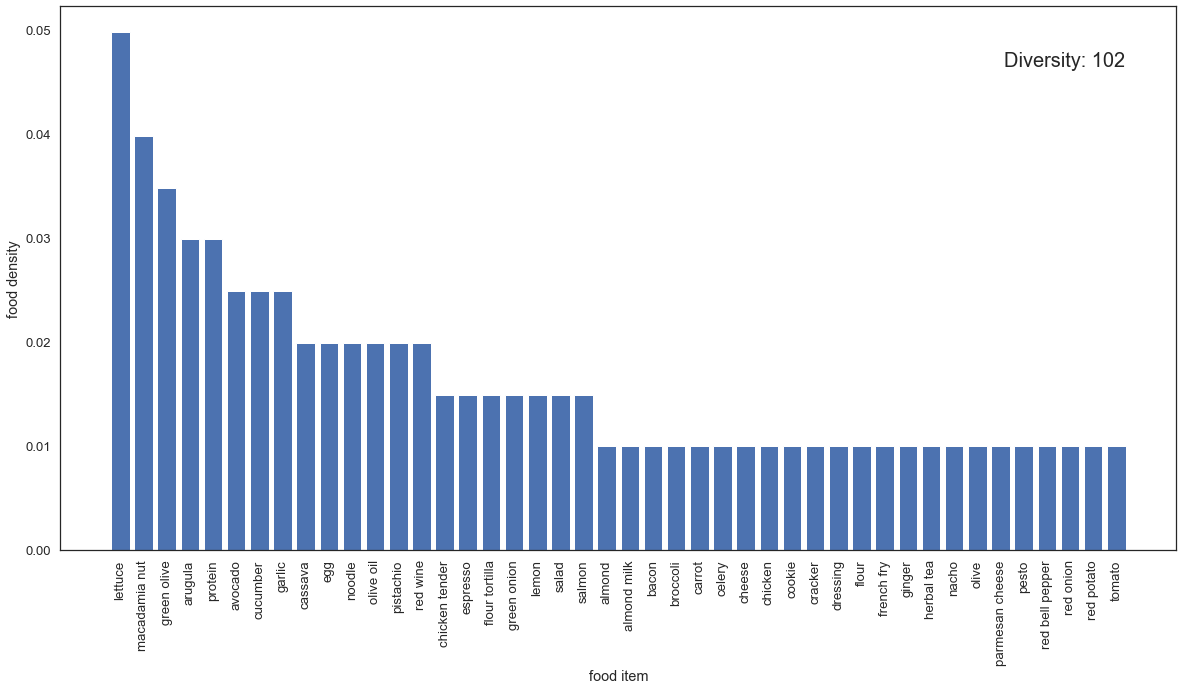

In [163]:
visualize_diversity('9bbi19040109',df_inter67)

In [164]:
df_diversity_base = pd.Series(diversity_base).to_frame()
df_diversity_base.rename({0:'diversity_base'}, axis='columns',inplace=True)
df_diversity_base.sort_values(by=['diversity_base'],inplace=True)
df_diversity_base.reset_index(inplace=True)
df_diversity_base.rename({'index':'ParticipantID'}, axis='columns',inplace=True)

In [165]:
df_diversity_com = df_diversity_base.set_index('ParticipantID').join(df_diversity_67.set_index('ParticipantID'),how='inner')


In [166]:
df_diversity_com

,diversity_base,diversity67
ParticipantID,,
9bbi18070044,15,25
9bbi19060133,23,90
9bbi19090145,33,28
9bbi19050121,35,26
9bbi19020074,36,43
...,...,...
9bbi19060130,100,100
9bbi19050122,101,48
9bbi18090058,106,61


## Comparison between TRE and SOC

In [167]:
df_group = pd.read_excel('firefighters_group.xlsx')

In [168]:
df_group

,ParticipantID,group
0,9bbi18050004,TRE
1,9bbi18050005,TRE
2,9bbi18050009,SOC
3,9bbi18050010,TRE
4,9bbi18060012,SOC
...,...,...
148,9bbi19110168,SOC
149,9bbi19110169,TRE
150,9bbi19110171,TRE
151,9bbi19120172,SOC


In [169]:
df_diversity_com = df_diversity_com.join(df_group.set_index('ParticipantID'),how='inner')

In [170]:
df_diversity_com

,diversity_base,diversity67,group
ParticipantID,,,
9bbi18070044,15,25,SOC
9bbi19060133,23,90,TRE
9bbi19090145,33,28,SOC
9bbi19050121,35,26,SOC
9bbi19020074,36,43,TRE
...,...,...,...
9bbi19060130,100,100,SOC
9bbi19050122,101,48,SOC
9bbi18090058,106,61,SOC


In [171]:
df_diversity_com['change'] = df_diversity_com['diversity67'] - df_diversity_com['diversity_base']
df_diversity_com.sort_values(by=['change'],inplace=True)
df_diversity_com

,diversity_base,diversity67,group,change
ParticipantID,,,,
9bbi19050122,101,48,SOC,-53
9bbi18090058,106,61,SOC,-45
9bbi19030092,108,67,TRE,-41
9bbi18050011,71,31,TRE,-40
9bbi19090143,76,37,SOC,-39
...,...,...,...,...
9bbi19030087,36,59,SOC,23
9bbi18080050,52,80,TRE,28
9bbi19040109,69,102,TRE,33


In [172]:
df_TRE = df_diversity_com[df_diversity_com['group']=='TRE']
df_SOC = df_diversity_com[df_diversity_com['group']=='SOC']

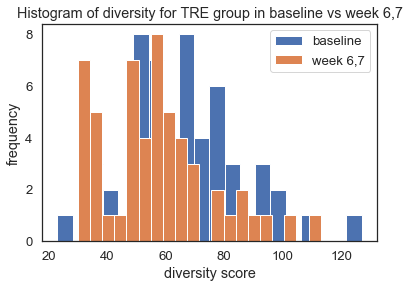

In [173]:
_=plt.hist(df_TRE['diversity_base'], bins=20,label='baseline')
_=plt.hist(df_TRE['diversity67'], bins=20,label='week 6,7')

plt.title("Histogram of diversity for TRE group in baseline vs week 6,7")
plt.xlabel("diversity score")
plt.ylabel("frequency")
plt.legend()

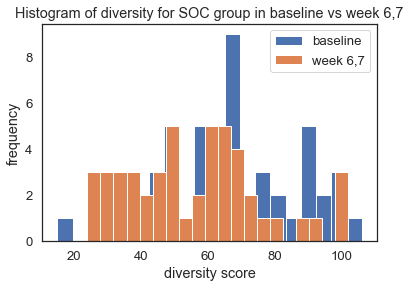

In [174]:
_=plt.hist(df_SOC['diversity_base'], bins=20,label='baseline')
_=plt.hist(df_SOC['diversity67'], bins=20,label='week 6,7')

plt.title("Histogram of diversity for SOC group in baseline vs week 6,7")
plt.xlabel("diversity score")
plt.ylabel("frequency")
plt.legend()

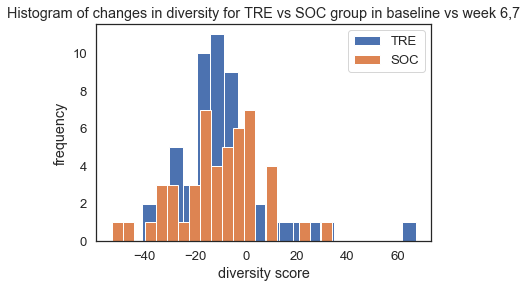

In [175]:
_=plt.hist(df_TRE['change'], bins=20,label='TRE')
_=plt.hist(df_SOC['change'], bins=20,label='SOC')

plt.title("Histogram of changes in diversity for TRE vs SOC group in baseline vs week 6,7")
plt.xlabel("diversity score")
plt.ylabel("frequency")
plt.legend()

In [176]:
df_diversity_com

,diversity_base,diversity67,group,change
ParticipantID,,,,
9bbi19050122,101,48,SOC,-53
9bbi18090058,106,61,SOC,-45
9bbi19030092,108,67,TRE,-41
9bbi18050011,71,31,TRE,-40
9bbi19090143,76,37,SOC,-39
...,...,...,...,...
9bbi19030087,36,59,SOC,23
9bbi18080050,52,80,TRE,28
9bbi19040109,69,102,TRE,33


In [177]:
df_diversity_com['change'].describe()

count    102.000000
mean     -10.392157
std       17.619272
min      -53.000000
25%      -19.000000
50%      -11.000000
75%       -3.000000
max       67.000000
Name: change, dtype: float64

In [178]:
# first quartile
df_diversity_com[:33]['group'].value_counts()

SOC    17
TRE    16
Name: group, dtype: int64

In [179]:
# second quartile
df_diversity_com[33:66]['group'].value_counts()

TRE    22
SOC    11
Name: group, dtype: int64

In [180]:
# third quartile
df_diversity_com[66:98]['group'].value_counts()

SOC    19
TRE    13
Name: group, dtype: int64

In [181]:
# fourth quartile
df_diversity_com[98:]['group'].value_counts()

TRE    3
SOC    1
Name: group, dtype: int64

In [182]:
df_diversity_com.groupby(['group'])['change'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
SOC,48.0,-10.875000,16.587133,-53.0,-19.25,-9.5,0.00,34.0
TRE,54.0,-9.962963,18.633469,-41.0,-19.00,-12.0,-5.25,67.0


In [183]:
from sklearn.preprocessing import quantile_transform

In [184]:
diversity

[11,
 25,
 42,
 55,
 66,
 75,
 79,
 86,
 89,
 93,
 96,
 99,
 103,
 106,
 112,
 118,
 125,
 131,
 139,
 142,
 145,
 148,
 153,
 158,
 162,
 163,
 167,
 171,
 174,
 177,
 178,
 185,
 188,
 191,
 193,
 197,
 201,
 205,
 209,
 211,
 213,
 215,
 217,
 218,
 219,
 221,
 224,
 231,
 231,
 234,
 236,
 240,
 243,
 245,
 246,
 248,
 252,
 256,
 258,
 261,
 265,
 266,
 268,
 270,
 272,
 273,
 275,
 280,
 282,
 286,
 290,
 290,
 295,
 301,
 301,
 303,
 307,
 313,
 313,
 319,
 320,
 322,
 323,
 324,
 325,
 325,
 326,
 327,
 329,
 332,
 333,
 333,
 334,
 336,
 341,
 344,
 345,
 347,
 347,
 348]

In [185]:
pd.DataFrame(diversity)

,0
0,11
1,25
2,42
3,55
4,66
...,...
95,344
96,345
97,347
98,347


In [186]:
quantile_transform(pd.Series(diversity).to_frame().T)

/Users/suijialu/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)
/Users/suijialu/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (1). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [187]:
frame = pd.Series(diversity).sort_values().to_frame()

In [188]:
frame

,0
0,11
1,25
2,42
3,55
4,66
...,...
95,344
96,345
98,347
97,347


In [189]:
df_index.query('ParticipantID == "9bbi19090151" and DayPassed <= 14') # outlier
# check whether all havr 14 days
# for each people, generate a histogram, np.unique (return counts and sort), divide by the sum of food items; x axis: unique food items
# seaborn, histogram, density plot; facetgrid want all have the same y axis
# matplotshare y == true
# lowest 5, middle 5, highest 5

,,Time,Logged entry,Beverage(b)/Food(f)/Water(w)/medication(m),Parsed food,DayPassed,group
ParticipantID,Date,,,,,,


In [190]:
df.query('comparison == "7v14"')

UndefinedVariableError: name 'comparison' is not defined